In [ ]:
# Importing necessary libraries
from astropy.table import Table
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import seaborn as sns
import joblib
import dask.dataframe as dd
from sklearn.preprocessing import LabelEncoder

In [ ]:
###### Loads the dataset into memory using Dask, which helps in efficiently handling large-scale data processing
# Read the parquet file using Dask
dft = dd.read_parquet("/home/samanehjavadinia/Co-op/Data/cfht_ngvs_lite_simbad.parquet")

# Set display options to show all columns
pd.set_option("display.max_columns", None)

# Print all column names
print(list(dft.columns))

# Define the features you want to keep
features = [
    "RA_in", 
    "DEC_in",

    "A_WORLD",
    "B_WORLD",
    "THETA_WORLD",
    "ERRA_WORLD",
    "ERRB_WORLD",
    "ERRTHETA_WORLD",
    "EBV",
    "U_MAG_ISO",
    "G_MAG_ISO",
    "R_MAG_ISO",
    "I_MAG_ISO",
    "Z_MAG_ISO",
    "U_MAGERR_ISO",
    "G_MAGERR_ISO",
    "R_MAGERR_ISO",
    "I_MAGERR_ISO",
    "Z_MAGERR_ISO",
    "U_MAG_APER1",
    "G_MAG_APER1",
    "R_MAG_APER1",
    "I_MAG_APER1",
    "Z_MAG_APER1",
    "U_MAG_APER3",
    "G_MAG_APER3",
    "R_MAG_APER3",
    "I_MAG_APER3",
    "Z_MAG_APER3",
    "U_MAG_APER5",
    "G_MAG_APER5",
    "R_MAG_APER5",
    "I_MAG_APER5",
    "Z_MAG_APER5",
    "U_MAGERR_APER1",
    "G_MAGERR_APER1",
    "R_MAGERR_APER1",
    "I_MAGERR_APER1",
    "Z_MAGERR_APER1",
    "U_MAGERR_APER3",
    "G_MAGERR_APER3",
    "R_MAGERR_APER3",
    "I_MAGERR_APER3",
    "Z_MAGERR_APER3",
    "U_MAGERR_APER5",
    "G_MAGERR_APER5",
    "R_MAGERR_APER5",
    "I_MAGERR_APER5",
    "Z_MAGERR_APER5",
    "U_MU_MAX",
    "G_MU_MAX",
    "R_MU_MAX",
    "I_MU_MAX",
    "Z_MU_MAX",
    "U_BACKGROUND",
    "G_BACKGROUND",
    "R_BACKGROUND",
    "I_BACKGROUND",
    "Z_BACKGROUND",
    "U_ISOAREA_IMAGE",
    "G_ISOAREA_IMAGE",
    "R_ISOAREA_IMAGE",
    "I_ISOAREA_IMAGE",
    "Z_ISOAREA_IMAGE",
    "U_FWHM_IMAGE",
    "G_FWHM_IMAGE",
    "R_FWHM_IMAGE",
    "I_FWHM_IMAGE",
    "Z_FWHM_IMAGE",
    "U_FLUX_RADIUS",
    "G_FLUX_RADIUS",
    "R_FLUX_RADIUS",
    "I_FLUX_RADIUS",
    "Z_FLUX_RADIUS",
    "U_KRON_RADIUS",
    "G_KRON_RADIUS",
    "R_KRON_RADIUS",
    "I_KRON_RADIUS",
    "Z_KRON_RADIUS",
    "U_PETRO_RADIUS",
    "G_PETRO_RADIUS",
    "R_PETRO_RADIUS",
    "I_PETRO_RADIUS",
    "Z_PETRO_RADIUS",
    "main_type",
]

# Select only the specified features
dft = dft[features]


# Drop rows where 'main_type' is NaN
dft_cleaned = dft.dropna(subset=["main_type"])

# Separate unlabeled data
unlabeled_data = dft[dft["main_type"].isna()]

In [ ]:
# Reading the data
dft = dft.compute()
print("Shape of dft:", dft.shape)

# Compute the Dask dataframe to Pandas dataframe for cleaned data
dft_cleaned_pd = dft_cleaned.compute()
print("Shape of dft_cleaned:", dft_cleaned_pd.shape)

# Compute the Dask dataframe to Pandas dataframe for unlabeled data
unlabeled_data_pd = unlabeled_data.compute()
print("Shape of unlabeled_data:", unlabeled_data_pd.shape)

In [ ]:
# Sample a fraction of the unlabeled data (e.g., 10%)
sampled_unlabeled_data = unlabeled_data.sample(frac=0.1)

# Compute the sampled data to a Pandas dataframe
# Sample a fraction of the unlabeled data
sampled_unlabeled_data_pd = sampled_unlabeled_data.compute()
print("Shape of sampled_unlabeled_data:", sampled_unlabeled_data_pd.shape)

# Display the sampled data
print(sampled_unlabeled_data_pd.head())

In [ ]:
sampled_unlabeled_data_pd.shape
dft = dft_cleaned_pd.copy()
unlabeled_data = sampled_unlabeled_data_pd.copy()
unlabeled_data.shape

In [ ]:
# # Reading the data
# dft = Table.read('/home/samanehjavadinia/Co-op/Data/ngvs_matched.fits')


Feature Engineering

In [ ]:
def drop_rows_with_99(df):
    """
    Drops rows from the DataFrame where any of the features have a value of 99.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The DataFrame with rows containing the value 99 dropped.
    """
    return  df[~(df == 99).any(axis=1)]


dft_cleaned = drop_rows_with_99(dft)
print(dft_cleaned.shape)

unlabeled_data_cleaned = drop_rows_with_99(unlabeled_data)
print(unlabeled_data_cleaned.shape)

In [ ]:
dft = dft_cleaned.copy()
unlabeled_data = unlabeled_data_cleaned.copy()

In [ ]:
dft.columns

In [ ]:
dft['Z_MAGERR_ISO'].hist()

In [ ]:
# for column in dft.columns:
#     plt.figure()
#     dft[column].hist()
#     plt.title(f'Histogram of {column} in Cleaned Dataset')
#     plt.xlabel(column)
#     plt.ylabel('Frequency')
#     plt.show()

In [ ]:
# Filter to omit rows where umag is more than 30 or err is more than 0.5
filtered_dft = dft[(dft['U_MAG_ISO'] <= 30) & (dft['U_MAGERR_ISO'] <= 0.5) & 
                   (dft['G_MAGERR_ISO'] <= 0.5) & (dft['R_MAGERR_ISO']<= 0.5) & 
                   (dft['I_MAGERR_ISO']<= 0.5) & (dft['Z_MAGERR_ISO']<= 0.5)]
filtered_unlabeled_data = unlabeled_data[(unlabeled_data['U_MAG_ISO'] <= 30) 
                        & (unlabeled_data['U_MAGERR_ISO'] <= 0.5) & (unlabeled_data['G_MAGERR_ISO'] <= 0.5) &
                (unlabeled_data['R_MAGERR_ISO']<= 0.5) & (unlabeled_data['I_MAGERR_ISO']<= 0.5)& (unlabeled_data['Z_MAGERR_ISO']<= 0.5)]

print(filtered_dft.shape)
print(filtered_unlabeled_data.shape)

In [ ]:
dft = filtered_dft.copy()
unlabeled_data = filtered_unlabeled_data.copy()

In [ ]:
print(dft.shape)
print(unlabeled_data.shape)


In [ ]:
unlabeled_data['main_type']

In [ ]:
# Function to get the value counts of columns with fewer than 5 unique values
def print_columns_with_fewer_than_5_unique_values(df):
    for column in df.columns:
        unique_values_count = df[column].nunique()
        if unique_values_count < 5:
            print(f"Value counts for column '{column}' (unique values: {unique_values_count}):")
            print(df[column].value_counts())
            print("\n")

print_columns_with_fewer_than_5_unique_values(dft)

In [ ]:
print_columns_with_fewer_than_5_unique_values(unlabeled_data)

Feature Engineering Section

In [ ]:
import pandas as pd
import numpy as np

def create_feature_differences_with_errors(df, feature_groups, error_groups, proxy_feature):
    """
    Create all combinations of differences for each group of features and 
    the square root of the sum of squared errors for each combination.
    
    :param df: pandas DataFrame containing the data
    :param feature_groups: List of lists, where each sublist contains feature names to create differences from
    :param error_groups: List of lists, where each sublist contains error feature names corresponding to the feature groups
    :return: DataFrame with new difference and error features and original features dropped
    """
    for group, error_group in zip(feature_groups, error_groups):
        print(group)
        print(error_group)
        # Create combinations of differences for each group
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                diff_feature_name = f'{group[i]}_minus_{group[j]}'
                error_feature_name = f'{error_group[i]}_minus_{error_group[j]}'
                
                df[diff_feature_name] = df[group[i]] - df[group[j]]
                df[error_feature_name] = np.sqrt(df[error_group[i]]**2 + df[error_group[j]]**2)

        # Drop the original features of the current group except the proxy feature
        # print(group)
        # Create a list of features to drop (all except proxy_feature)
        features_to_drop = [feature for feature in group if feature != proxy_feature]
        df.drop(columns=features_to_drop, inplace=True)
        df.drop(columns=error_group, inplace=True)
    
    return df



# Define the proxy feature to retain
proxy_feature = 'G_MAG_ISO'

# Define the feature groups and corresponding error groups
feature_groups = [
    ['U_MAG_ISO', 'G_MAG_ISO', 'R_MAG_ISO',
       'I_MAG_ISO', 'Z_MAG_ISO']
]

error_groups = [
    ['U_MAGERR_ISO', 'G_MAGERR_ISO',
       'R_MAGERR_ISO', 'I_MAGERR_ISO', 'Z_MAGERR_ISO']
]




# Apply the function
dft = create_feature_differences_with_errors(dft, feature_groups, error_groups, proxy_feature)
unlabeled_data = create_feature_differences_with_errors(unlabeled_data, feature_groups, error_groups, proxy_feature)
print(dft.columns)
print(unlabeled_data.columns)




In [ ]:
pd.set_option('display.max_columns', None)
dft.describe()

In [ ]:
dft['main_type'].value_counts()

In [ ]:
# Create and display the pie chart of the new column
category_counts = dft['main_type'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Bar Chart of Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Count the occurrences of each category
category_counts = dft['main_type'].value_counts()

# Specify the categorical column
category_column = 'main_type'

# Define the threshold for rare categories
threshold = 1000  # Categories with counts less than or equal to this will be grouped into "Other"

# Count the occurrences of each category
category_counts = dft[category_column].value_counts()

# Identify the rare categories
rare_categories = category_counts[category_counts <= threshold].index

# Create a new column with grouped categories
dft['grouped_category'] = dft[category_column].apply(lambda x: 'Other' if x in rare_categories else x)

# Print the number of different categories in the new column
num_categories = dft['grouped_category'].nunique()
print(f'The number of different categories in the new grouped column: {num_categories}')



# Count the occurrences of each category
category_counts = dft['grouped_category'].value_counts()


# Create and display the pie chart of the new column
category_counts = dft['grouped_category'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Grouped Categories')
plt.show()

In [ ]:
# Create a bar chart
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Bar Chart of Category Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [ ]:
dft['grouped_category'].value_counts()

In [ ]:
dft.columns

In [ ]:
dft = dft.drop(columns='main_type')

In [ ]:
# Get the unique types in the 'grouped_category' column
unique_types = dft['grouped_category'].apply(type).unique()
print("Different types in 'grouped_category' column:", unique_types)

In [ ]:
# Ensure all values in 'grouped_category' are strings
dft['grouped_category'] = dft['grouped_category'].astype(str)

In [ ]:
df = dft.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Label Encoding
label_encoder = LabelEncoder()
df['main_type_encoded'] = label_encoder.fit_transform(df['grouped_category'])

# Save the encoder to disk
joblib.dump(label_encoder, 'label_encoder.pkl')

In [ ]:
df.columns

In [ ]:
 # Calculate the correlation matrix
correlation_matrix = df.corr()

# Get the correlations of the features with the target
correlation_with_target = correlation_matrix['main_type_encoded'].drop('main_type_encoded')


# Sort correlations
sorted_correlations = correlation_with_target.sort_values()

# Plot the correlations
plt.figure(figsize=(50, 50))
sns.barplot(x=sorted_correlations.values, y=sorted_correlations.index, palette="viridis")
plt.title('Feature Correlations with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [ ]:
# from pandas.plotting import scatter_matrix

# attributes = [ 'iC', 'iCerr', 'ebv', 'background_g', 'ug0', 'gi0', 'iz0', 'p_star',
#        'p_gc', 'p_galx', 'umag_minus_gmag', 'umag_minus_rmag',
#        'umag_minus_imag', 'umag_minus_zmag', 'gmag_minus_rmag',
#        'gmag_minus_imag', 'gmag_minus_zmag', 'rmag_minus_imag',
#        'rmag_minus_zmag', 'imag_minus_zmag', 'uerr_minus_gerr',
#        'uerr_minus_rerr', 'uerr_minus_ierr', 'uerr_minus_zerr',
#        'gerr_minus_rerr', 'gerr_minus_ierr', 'gerr_minus_zerr',
#        'rerr_minus_ierr', 'rerr_minus_zerr', 'ierr_minus_zerr',
#        'grouped_category', 'main_type_encoded']
# scatter_matrix(df[attributes], figsize=(40, 40))
# plt.show()

In [ ]:
df = df.drop(columns=[ 'grouped_category'])

In [ ]:
unlabeled_data.columns

In [ ]:
unlabeled_data['main_type'].value_counts()

In [ ]:
unlabeled_data = unlabeled_data.drop(columns=[ 'main_type'])

In [ ]:
unlabeled_data.columns

In [ ]:
import os

# Verify the directory structure
print(os.listdir('/home/samanehjavadinia/Co-op/Data/'))

In [ ]:
# Save the train and test datasets to CSV files
df.to_csv('/home/samanehjavadinia/Co-op/Data/CFHT_modified_dataset.csv', index=False)
unlabeled_data.to_csv('/home/samanehjavadinia/Co-op/Data/CFHT_unlabeled_data.csv', index=False)

#############LOading
###########
#######
#########
#########


In [2]:
# Importing necessary libraries
from astropy.table import Table
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time

from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils import resample
import seaborn as sns
import joblib

In [3]:
# If you want to load the data later, you can use the following code
df = pd.read_csv('/home/samanehjavadinia/Co-op/Data/CFHT_modified_dataset.csv')
unlabeled_data = pd.read_csv('/home/samanehjavadinia/Co-op/Data/CFHT_unlabeled_data.csv')
# Load the encoder from disk
label_encoder = joblib.load('label_encoder.pkl')

In [4]:

# File path
file_path = '/home/samanehjavadinia/Co-op/Data/NGVS_galaxies.csv'

# Read the CSV file with proper delimiter
galaxies_df = pd.read_csv(file_path, delimiter=r'\s{2,}', engine='python')

# Renaming the specified columns in the galaxies dataset
galaxies_df.rename(columns={'NGVS_ra(deg)': 'RA_in', 'NGVS_dec(deg)': 'DEC_in'}, inplace=True)

# Display the updated dataframe
print(galaxies_df.head())

                   # NGVS_name Nickname       RA_in     DEC_in  g_mag_total
0  NGVSJ12:03:45.06+27:37:02.0    NGVS1  180.937750  27.617222    16.669001
1  NGVSJ12:04:51.83+26:59:33.1    NGVS2  181.215958  26.992528    13.626000
2  NGVSJ12:07:45.73+12:03:37.0    NGVS3  181.940552  12.060277    20.582001
3  NGVSJ12:08:01.21+12:48:56.0    NGVS4  182.005060  12.815564    19.448000
4  NGVSJ12:08:04.43+13:13:17.0    NGVS5  182.018458  13.221389    20.551001


In [5]:

# Encode the class labels
df['class'] = label_encoder.inverse_transform(df['main_type_encoded'])

np.unique(df['class'])



array(['BClG', 'Galaxy', 'GinCl', 'GlCl', 'GlCl?_Candidate', 'Other',
       'QSO', 'Star'], dtype=object)

CSV file 'selected_galaxies.csv' created successfully.


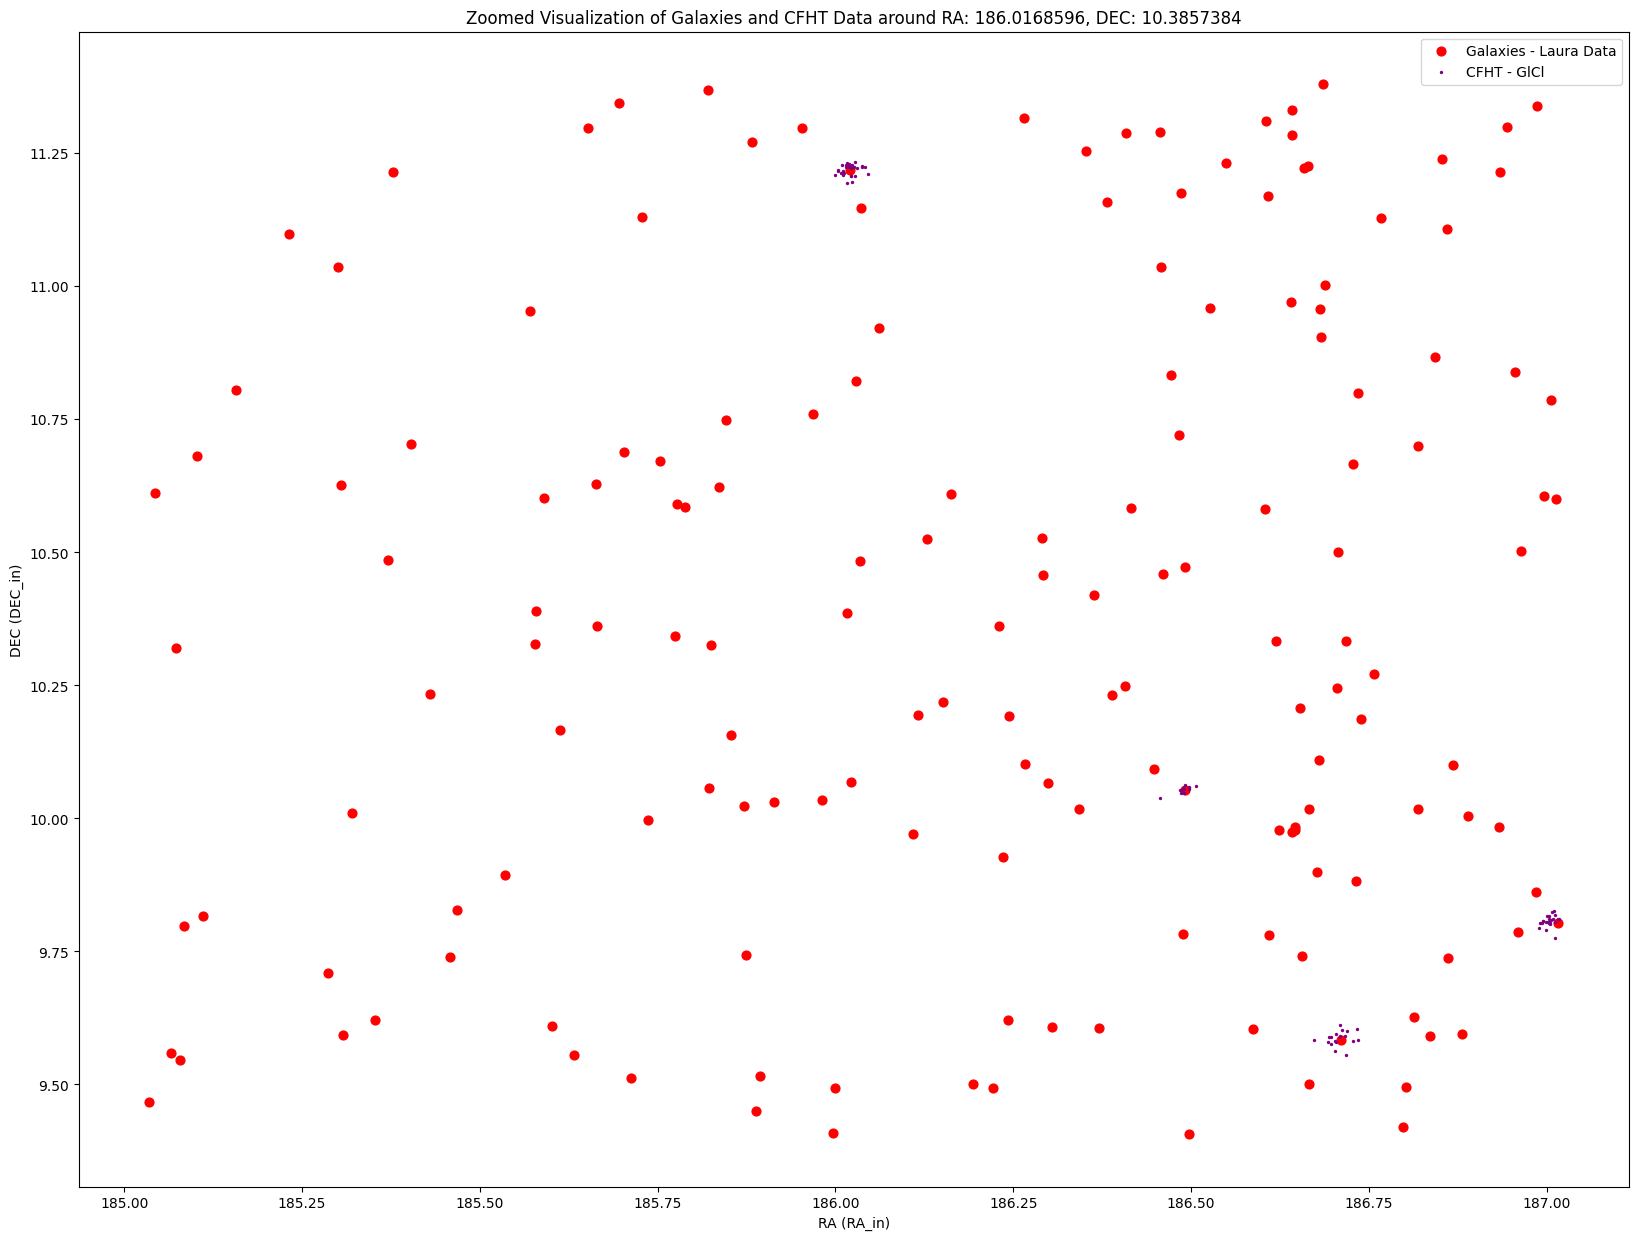

In [6]:

# Select a galaxy within the RA_in range 186-190
selected_galaxy = galaxies_df[(galaxies_df['RA_in'] >= 186) & (galaxies_df['RA_in'] <= 190)].iloc[10]  # Change this to select a different galaxy
center_ra = selected_galaxy['RA_in']
center_dec = selected_galaxy['DEC_in']

# Filter data within +/- 1 degree of the selected galaxy's coordinates
galaxies_zoom_df = galaxies_df[
    (galaxies_df['RA_in'] >= center_ra - 1) & (galaxies_df['RA_in'] <= center_ra + 1) &
    (galaxies_df['DEC_in'] >= center_dec - 1) & (galaxies_df['DEC_in'] <= center_dec + 1)
]

df_zoom = df[
    (df['RA_in'] >= center_ra - 1) & (df['RA_in'] <= center_ra + 1) &
    (df['DEC_in'] >= center_dec - 1) & (df['DEC_in'] <= center_dec + 1)
]



##############


# Combine the filtered data into a single DataFrame
combined_df = pd.concat([galaxies_zoom_df[['RA_in', 'DEC_in']], df_zoom[['RA_in', 'DEC_in']]])



# Rename columns to 'RA' and 'DEC'
combined_df.rename(columns={'RA_in': 'RA', 'DEC_in': 'DEC'}, inplace=True)

# Save the DataFrame to a CSV file
combined_df.to_csv('selected_galaxies.csv', index=False)

print("CSV file 'selected_galaxies.csv' created successfully.")
###########





# Plotting
plt.figure(figsize=(20, 15))

# Plot filtered galaxies in red with smaller markers and label 'Galaxies - Big data'
plt.scatter(galaxies_zoom_df['RA_in'], galaxies_zoom_df['DEC_in'], color='red', s=40, label='Galaxies - Laura Data')

# # Define classes and corresponding colors
# classes = ['BClG', 'Galaxy', 'GinCl', 'GlCl', 'GlCl?_Candidate', 'Other', 'QSO', 'Star']
# colors = ['green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'cyan']

# # Define classes and corresponding colors
# classes = [ 'GlCl', 'GlCl?_Candidate']
# colors = ['purple', 'orange']

# Define classes and corresponding colors
classes = [ 'GlCl']
colors = ['purple']




# Plot filtered CFHT modified data with different colors for different classes and smaller markers
for i, class_name in enumerate(classes):
    class_data = df_zoom[df_zoom['class'] == class_name]
    size = 2 if class_name == 'GlCl' else 5  # Different size for GlCl class
    plt.scatter(class_data['RA_in'], class_data['DEC_in'], color=colors[i % len(colors)], s=size, label=f'CFHT - {class_name}')

plt.xlabel('RA (RA_in)')
plt.ylabel('DEC (DEC_in)')
plt.legend()
plt.title(f'Zoomed Visualization of Galaxies and CFHT Data around RA: {center_ra}, DEC: {center_dec}')
plt.show()

CSV files created successfully.


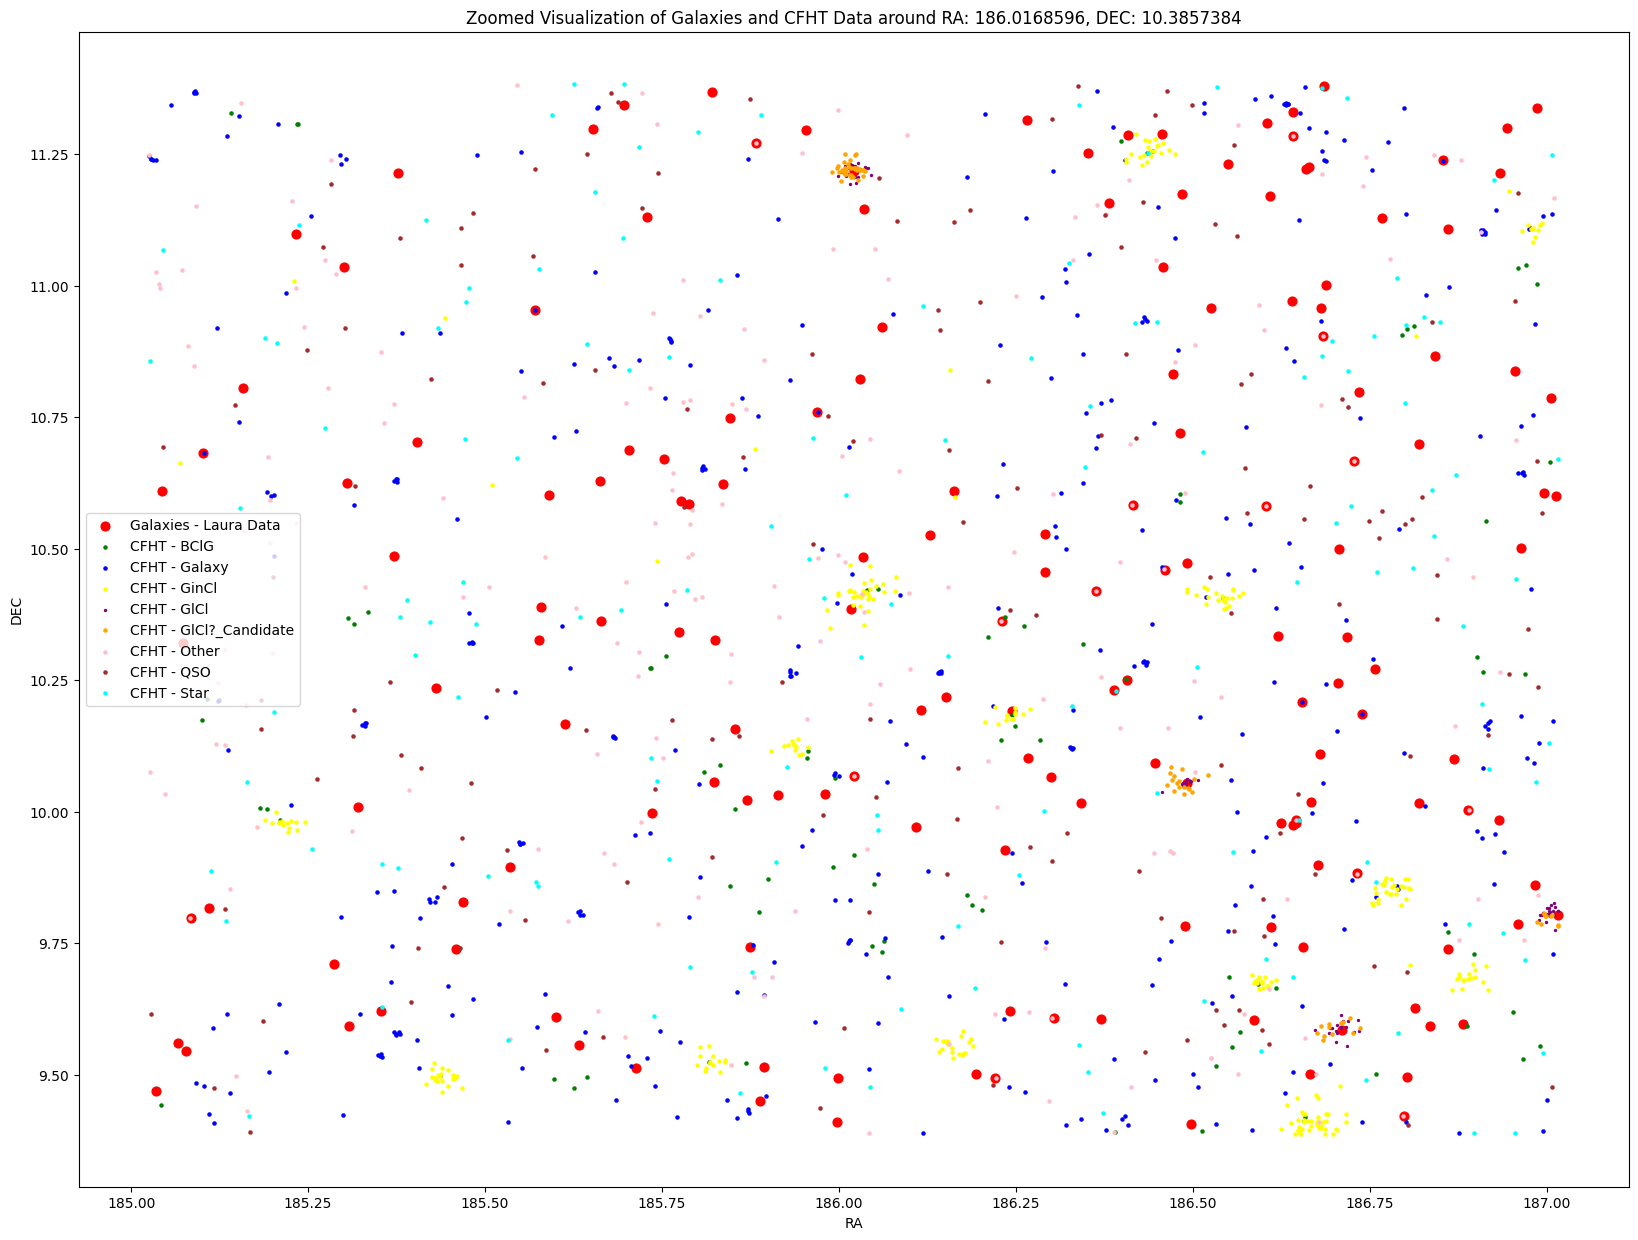

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Select a galaxy within the RA_in range 186-190
selected_galaxy = galaxies_df[(galaxies_df['RA_in'] >= 186) & (galaxies_df['RA_in'] <= 190)].iloc[10].copy()
center_ra = selected_galaxy['RA_in']
center_dec = selected_galaxy['DEC_in']
# Creating a DataFrame for the selected galaxy
selected_galaxy_df = pd.DataFrame([selected_galaxy])

# Filter data within +/- 1 degree of the selected galaxy's coordinates
galaxies_zoom_df = galaxies_df[
    (galaxies_df['RA_in'] >= center_ra - 1) & (galaxies_df['RA_in'] <= center_ra + 1) &
    (galaxies_df['DEC_in'] >= center_dec - 1) & (galaxies_df['DEC_in'] <= center_dec + 1)
].copy()

df_zoom = df[
    (df['RA_in'] >= center_ra - 1) & (df['RA_in'] <= center_ra + 1) &
    (df['DEC_in'] >= center_dec - 1) & (df['DEC_in'] <= center_dec + 1)
].copy()

# Rename columns to 'RA' and 'DEC' for consistency
selected_galaxy_df.rename(columns={'RA_in': 'RA', 'DEC_in': 'DEC'}, inplace=True)
galaxies_zoom_df.rename(columns={'RA_in': 'RA', 'DEC_in': 'DEC'}, inplace=True)
df_zoom.rename(columns={'RA_in': 'RA', 'DEC_in': 'DEC'}, inplace=True)




# Adding additional columns

galaxies_zoom_df['name'] = 'Laura Galaxy'
galaxies_zoom_df['color'] = 'blue'
galaxies_zoom_df['radius'] = 20

# Define classes and corresponding colors
classes = ['BClG', 'Galaxy', 'GinCl', 'GlCl', 'GlCl?_Candidate', 'Other', 'QSO', 'Star']
colors = ['green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'cyan']
class_color_map = dict(zip(classes, colors))

# Adding color and radius columns to df_zoom
df_zoom['color'] = df_zoom['class'].map(class_color_map)
df_zoom['radius'] = df_zoom['class'].apply(lambda x: 15 if x == 'GlCl' else 10)
df_zoom.loc[:, 'name'] = df_zoom['class']

# Save the DataFrames to CSV files
galaxies_zoom_df.to_csv('galaxies_zoom.csv', index=False)
df_zoom.to_csv('df_zoom.csv', index=False)

# Combine the data into a single DataFrame for visualization with class information
combined_df = pd.concat([galaxies_zoom_df[['RA', 'DEC', 'name', 'color', 'radius']], df_zoom[['RA', 'DEC', 'name', 'color', 'radius']]])
combined_df.rename(columns={'class': 'name'}, inplace=True)

# Save the combined DataFrame to a CSV file
combined_df.to_csv('combined.csv', index=False)

print("CSV files created successfully.")









# Plotting
plt.figure(figsize=(20, 15))

# Plot filtered galaxies in red with smaller markers and label 'Galaxies - Laura Data'
plt.scatter(galaxies_zoom_df['RA'], galaxies_zoom_df['DEC'], color='red', s=40, label='Galaxies - Laura Data')

# Define classes and corresponding colors
classes = ['BClG', 'Galaxy', 'GinCl', 'GlCl', 'GlCl?_Candidate', 'Other', 'QSO', 'Star']
colors = ['green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'cyan']

# Plot filtered CFHT modified data with different colors for different classes and smaller markers
for i, class_name in enumerate(classes):
    class_data = df_zoom[df_zoom['class'] == class_name]
    size = 2 if class_name == 'GlCl' else 5  # Different size for GlCl class
    plt.scatter(class_data['RA'], class_data['DEC'], color=colors[i % len(colors)], s=size, label=f'CFHT - {class_name}')

plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend()
plt.title(f'Zoomed Visualization of Galaxies and CFHT Data around RA: {center_ra}, DEC: {center_dec}')
plt.show()


In [8]:
df_zoom[['RA', 'DEC', 'class', 'color', 'radius']]

,RA,DEC,class,color,radius
9860,186.603931,10.581872,Other,pink,10
9869,186.823411,10.599256,QSO,brown,10
9873,186.838734,10.612339,Star,cyan,10
9877,186.665437,10.619004,QSO,brown,10
9882,186.967790,10.640063,Galaxy,blue,10
...,...,...,...,...,...
31401,185.548872,9.937846,Galaxy,blue,10
31402,185.553708,9.940122,Galaxy,blue,10
31403,185.548491,9.942631,Galaxy,blue,10
31412,185.110656,9.424196,Galaxy,blue,10


In [9]:
print(df.columns)

Index(['RA_in', 'DEC_in', 'A_WORLD', 'B_WORLD', 'THETA_WORLD', 'ERRA_WORLD',
       'ERRB_WORLD', 'ERRTHETA_WORLD', 'EBV', 'G_MAG_ISO', 'U_MAG_APER1',
       'G_MAG_APER1', 'R_MAG_APER1', 'I_MAG_APER1', 'Z_MAG_APER1',
       'U_MAG_APER3', 'G_MAG_APER3', 'R_MAG_APER3', 'I_MAG_APER3',
       'Z_MAG_APER3', 'U_MAG_APER5', 'G_MAG_APER5', 'R_MAG_APER5',
       'I_MAG_APER5', 'Z_MAG_APER5', 'U_MAGERR_APER1', 'G_MAGERR_APER1',
       'R_MAGERR_APER1', 'I_MAGERR_APER1', 'Z_MAGERR_APER1', 'U_MAGERR_APER3',
       'G_MAGERR_APER3', 'R_MAGERR_APER3', 'I_MAGERR_APER3', 'Z_MAGERR_APER3',
       'U_MAGERR_APER5', 'G_MAGERR_APER5', 'R_MAGERR_APER5', 'I_MAGERR_APER5',
       'Z_MAGERR_APER5', 'U_MU_MAX', 'G_MU_MAX', 'R_MU_MAX', 'I_MU_MAX',
       'Z_MU_MAX', 'U_BACKGROUND', 'G_BACKGROUND', 'R_BACKGROUND',
       'I_BACKGROUND', 'Z_BACKGROUND', 'U_ISOAREA_IMAGE', 'G_ISOAREA_IMAGE',
       'R_ISOAREA_IMAGE', 'I_ISOAREA_IMAGE', 'Z_ISOAREA_IMAGE', 'U_FWHM_IMAGE',
       'G_FWHM_IMAGE', 'R_FWHM_IMAGE', 'I

In [10]:
np.unique(df['class'])

array(['BClG', 'Galaxy', 'GinCl', 'GlCl', 'GlCl?_Candidate', 'Other',
       'QSO', 'Star'], dtype=object)

In [11]:
df.shape

(47247, 97)

In [12]:
# Decode the labels in the labeled dataset
decoded_labels = label_encoder.inverse_transform(df['main_type_encoded'])

In [13]:
np.unique(decoded_labels)

array(['BClG', 'Galaxy', 'GinCl', 'GlCl', 'GlCl?_Candidate', 'Other',
       'QSO', 'Star'], dtype=object)

In [14]:
# Assuming 'arr' is your numpy array
arr_series = pd.Series(decoded_labels)
value_counts = arr_series.value_counts()
print(value_counts)

Galaxy             14538
Other               6582
GinCl               6344
GlCl                5025
Star                4448
GlCl?_Candidate     4160
QSO                 4036
BClG                2114
dtype: int64


In [15]:
df.head()

,RA_in,DEC_in,A_WORLD,B_WORLD,THETA_WORLD,ERRA_WORLD,ERRB_WORLD,ERRTHETA_WORLD,EBV,G_MAG_ISO,...,G_MAG_ISO_minus_Z_MAG_ISO,G_MAGERR_ISO_minus_Z_MAGERR_ISO,R_MAG_ISO_minus_I_MAG_ISO,R_MAGERR_ISO_minus_I_MAGERR_ISO,R_MAG_ISO_minus_Z_MAG_ISO,R_MAGERR_ISO_minus_Z_MAGERR_ISO,I_MAG_ISO_minus_Z_MAG_ISO,I_MAGERR_ISO_minus_Z_MAGERR_ISO,main_type_encoded,class
0,190.922129,11.573554,0.000069,0.000064,-85.97,2.436208e-06,2.292044e-06,-89.7,0.027,24.4150,...,1.091501,0.056218,0.444000,0.041158,0.526400,0.057651,0.082399,0.058054,3,GlCl
1,191.027148,11.572200,0.000115,0.000112,-58.92,6.379154e-07,5.936365e-07,-31.4,0.029,21.4813,...,1.066900,0.008326,0.333199,0.006224,0.490099,0.008732,0.156900,0.008832,3,GlCl
2,190.839513,11.573298,0.000097,0.000092,87.76,8.282170e-07,7.726438e-07,-88.7,0.026,22.5600,...,0.900700,0.017591,0.302401,0.012062,0.410900,0.018251,0.108500,0.018892,3,GlCl
3,190.946469,11.573469,0.000113,0.000095,72.98,1.755852e-06,1.296500e-06,67.7,0.027,23.0577,...,1.117100,0.026343,0.282200,0.018515,0.430300,0.026565,0.148100,0.027577,3,GlCl
4,190.910470,11.574138,0.000069,0.000067,51.42,1.578995e-06,1.482429e-06,19.2,0.026,23.8594,...,0.893000,0.048098,0.363600,0.029019,0.266399,0.049018,-0.097200,0.048259,3,GlCl


In [16]:
# df_angdist = df.copy()
# df = df.drop(columns = 'angDist')

In [17]:
df.columns

Index(['RA_in', 'DEC_in', 'A_WORLD', 'B_WORLD', 'THETA_WORLD', 'ERRA_WORLD',
       'ERRB_WORLD', 'ERRTHETA_WORLD', 'EBV', 'G_MAG_ISO', 'U_MAG_APER1',
       'G_MAG_APER1', 'R_MAG_APER1', 'I_MAG_APER1', 'Z_MAG_APER1',
       'U_MAG_APER3', 'G_MAG_APER3', 'R_MAG_APER3', 'I_MAG_APER3',
       'Z_MAG_APER3', 'U_MAG_APER5', 'G_MAG_APER5', 'R_MAG_APER5',
       'I_MAG_APER5', 'Z_MAG_APER5', 'U_MAGERR_APER1', 'G_MAGERR_APER1',
       'R_MAGERR_APER1', 'I_MAGERR_APER1', 'Z_MAGERR_APER1', 'U_MAGERR_APER3',
       'G_MAGERR_APER3', 'R_MAGERR_APER3', 'I_MAGERR_APER3', 'Z_MAGERR_APER3',
       'U_MAGERR_APER5', 'G_MAGERR_APER5', 'R_MAGERR_APER5', 'I_MAGERR_APER5',
       'Z_MAGERR_APER5', 'U_MU_MAX', 'G_MU_MAX', 'R_MU_MAX', 'I_MU_MAX',
       'Z_MU_MAX', 'U_BACKGROUND', 'G_BACKGROUND', 'R_BACKGROUND',
       'I_BACKGROUND', 'Z_BACKGROUND', 'U_ISOAREA_IMAGE', 'G_ISOAREA_IMAGE',
       'R_ISOAREA_IMAGE', 'I_ISOAREA_IMAGE', 'Z_ISOAREA_IMAGE', 'U_FWHM_IMAGE',
       'G_FWHM_IMAGE', 'R_FWHM_IMAGE', 'I

In [18]:
df_BD = df.copy()
unlabeled_data_BD = unlabeled_data.copy()

In [19]:
df = df.drop(columns = ['RA_in', 'DEC_in', 'class'])
unlabeled_data = unlabeled_data.drop(columns = ['RA_in', 'DEC_in'])

In [20]:
df['main_type_encoded'].value_counts()

1    14538
5     6582
2     6344
3     5025
7     4448
4     4160
6     4036
0     2114
Name: main_type_encoded, dtype: int64

In [21]:
df.columns

Index(['A_WORLD', 'B_WORLD', 'THETA_WORLD', 'ERRA_WORLD', 'ERRB_WORLD',
       'ERRTHETA_WORLD', 'EBV', 'G_MAG_ISO', 'U_MAG_APER1', 'G_MAG_APER1',
       'R_MAG_APER1', 'I_MAG_APER1', 'Z_MAG_APER1', 'U_MAG_APER3',
       'G_MAG_APER3', 'R_MAG_APER3', 'I_MAG_APER3', 'Z_MAG_APER3',
       'U_MAG_APER5', 'G_MAG_APER5', 'R_MAG_APER5', 'I_MAG_APER5',
       'Z_MAG_APER5', 'U_MAGERR_APER1', 'G_MAGERR_APER1', 'R_MAGERR_APER1',
       'I_MAGERR_APER1', 'Z_MAGERR_APER1', 'U_MAGERR_APER3', 'G_MAGERR_APER3',
       'R_MAGERR_APER3', 'I_MAGERR_APER3', 'Z_MAGERR_APER3', 'U_MAGERR_APER5',
       'G_MAGERR_APER5', 'R_MAGERR_APER5', 'I_MAGERR_APER5', 'Z_MAGERR_APER5',
       'U_MU_MAX', 'G_MU_MAX', 'R_MU_MAX', 'I_MU_MAX', 'Z_MU_MAX',
       'U_BACKGROUND', 'G_BACKGROUND', 'R_BACKGROUND', 'I_BACKGROUND',
       'Z_BACKGROUND', 'U_ISOAREA_IMAGE', 'G_ISOAREA_IMAGE', 'R_ISOAREA_IMAGE',
       'I_ISOAREA_IMAGE', 'Z_ISOAREA_IMAGE', 'U_FWHM_IMAGE', 'G_FWHM_IMAGE',
       'R_FWHM_IMAGE', 'I_FWHM_IMAGE', 'Z_FW

In [22]:
df.loc[45518]

A_WORLD                            8.370858e-04
B_WORLD                            4.311101e-04
THETA_WORLD                        6.626000e+01
ERRA_WORLD                         9.668147e-07
ERRB_WORLD                         5.741863e-07
                                       ...     
R_MAG_ISO_minus_Z_MAG_ISO         -1.654630e+01
R_MAGERR_ISO_minus_Z_MAGERR_ISO    1.000000e-03
I_MAG_ISO_minus_Z_MAG_ISO          2.699986e-01
I_MAGERR_ISO_minus_Z_MAGERR_ISO    1.220656e-03
main_type_encoded                  1.000000e+00
Name: 45518, Length: 94, dtype: float64

In [23]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['main_type_encoded'], random_state=42)

# Further split the training data into a training set and a calibration set
train_df, calib_df = train_test_split(train_df, test_size=0.2, stratify=train_df['main_type_encoded'], random_state=42)

# Separate X and y for training and testing
X_train = train_df.drop(columns=['main_type_encoded'])
y_train = train_df['main_type_encoded']
X_test = test_df.drop(columns=['main_type_encoded'])
y_test = test_df['main_type_encoded']
X_calib = calib_df.drop(columns=['main_type_encoded'])
y_calib = calib_df['main_type_encoded']

# # Save the original indices for reference
# train_indices = train_df['original_index']
# test_indices = test_df['original_index']
# calib_indices = calib_df['original_index']

In [74]:
train_df.shape

(30237, 94)

In [75]:
test_df.shape

(9450, 94)

In [76]:
unlabeled_data.shape

(1587694, 93)

In [24]:
calib_df.loc[45518]

A_WORLD                            8.370858e-04
B_WORLD                            4.311101e-04
THETA_WORLD                        6.626000e+01
ERRA_WORLD                         9.668147e-07
ERRB_WORLD                         5.741863e-07
                                       ...     
R_MAG_ISO_minus_Z_MAG_ISO         -1.654630e+01
R_MAGERR_ISO_minus_Z_MAGERR_ISO    1.000000e-03
I_MAG_ISO_minus_Z_MAG_ISO          2.699986e-01
I_MAGERR_ISO_minus_Z_MAGERR_ISO    1.220656e-03
main_type_encoded                  1.000000e+00
Name: 45518, Length: 94, dtype: float64

In [25]:
y_test.value_counts()

1    2908
5    1316
2    1269
3    1005
7     890
4     832
6     807
0     423
Name: main_type_encoded, dtype: int64

In [26]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def scale_numeric_columns(train_df, test_df, calib_df):
    # Identify non-numeric and numeric columns
    non_numeric_columns = train_df.select_dtypes(include=['object']).columns
    numeric_columns = train_df.select_dtypes(exclude=['object']).columns

    # Separate non-numeric and numeric columns
    train_non_numeric = train_df[non_numeric_columns]
    train_numeric = train_df[numeric_columns]

    test_non_numeric = test_df[non_numeric_columns]
    test_numeric = test_df[numeric_columns]
    
    calib_non_numeric = calib_df[non_numeric_columns]
    calib_numeric = calib_df[numeric_columns]

    # Handle missing values in numeric columns
    train_numeric = train_numeric.dropna()
    test_numeric = test_numeric.dropna()
    calib_numeric = calib_numeric.dropna()

    # Scale the numeric columns
    scaler = MinMaxScaler()
    train_numeric_scaled = scaler.fit_transform(train_numeric)
    test_numeric_scaled = scaler.transform(test_numeric)
    calib_numeric_scaled = scaler.transform(calib_numeric)
    
    # Convert the scaled array back to DataFrames
    train_numeric_scaled = pd.DataFrame(train_numeric_scaled, columns=numeric_columns)
    test_numeric_scaled = pd.DataFrame(test_numeric_scaled, columns=numeric_columns)
    calib_numeric_scaled = pd.DataFrame(calib_numeric_scaled, columns=numeric_columns)
    
    # Combine the scaled numeric columns with the non-numeric columns
    train_scaled = pd.concat([train_numeric_scaled, train_non_numeric.reset_index(drop=True)], axis=1)
    test_scaled = pd.concat([test_numeric_scaled, test_non_numeric.reset_index(drop=True)], axis=1)
    calib_scaled = pd.concat([calib_numeric_scaled, calib_non_numeric.reset_index(drop=True)], axis=1)

    return train_scaled, test_scaled, calib_scaled

# Example usage
# df = pd.read_csv('your_dataset.csv')  # Load your dataset
X_train_scaled, X_test_scaled, X_calib_scaled = scale_numeric_columns(X_train, X_test, X_calib )
# print("Scaled train data:", X_train_scaled.head())
# print("Scaled test data:", X_test_scaled.head())

X_train = X_train_scaled.copy()
X_test = X_test_scaled.copy()
X_calib = X_calib_scaled.copy()

In [27]:
X_train.head()

,A_WORLD,B_WORLD,THETA_WORLD,ERRA_WORLD,ERRB_WORLD,ERRTHETA_WORLD,EBV,G_MAG_ISO,U_MAG_APER1,G_MAG_APER1,...,G_MAG_ISO_minus_I_MAG_ISO,G_MAGERR_ISO_minus_I_MAGERR_ISO,G_MAG_ISO_minus_Z_MAG_ISO,G_MAGERR_ISO_minus_Z_MAGERR_ISO,R_MAG_ISO_minus_I_MAG_ISO,R_MAGERR_ISO_minus_I_MAGERR_ISO,R_MAG_ISO_minus_Z_MAG_ISO,R_MAGERR_ISO_minus_Z_MAGERR_ISO,I_MAG_ISO_minus_Z_MAG_ISO,I_MAGERR_ISO_minus_Z_MAGERR_ISO
0,0.024732,0.089315,0.872500,0.097828,0.182565,0.911111,0.206897,0.592900,0.625764,0.609478,...,0.557079,0.027352,0.603573,0.031934,0.234965,0.008679,0.234530,0.014623,0.748031,0.015494
1,0.033972,0.117682,0.746389,0.090270,0.160955,0.722778,0.103448,0.534110,0.589514,0.542799,...,0.547913,0.011047,0.594972,0.012478,0.925694,0.007652,0.898080,0.007851,0.743171,0.006351
2,0.154954,0.255115,0.150389,0.019879,0.017325,0.141667,0.068966,0.180926,0.310870,0.167130,...,0.341182,0.000542,0.461871,0.000699,0.915982,0.000599,0.887754,0.000629,0.737508,0.000534
3,0.012962,0.040020,0.048333,0.018920,0.029391,0.043889,0.327586,0.532476,0.493452,0.433911,...,0.327807,0.013027,0.429299,0.017032,0.915886,0.012514,0.880490,0.013730,0.696216,0.013491
4,0.144788,0.260149,0.430833,0.037835,0.040107,0.420556,0.206897,0.267986,0.421410,0.386682,...,0.346533,0.001495,0.460577,0.002514,0.918459,0.001404,0.888756,0.002033,0.729560,0.001986


Original Data Labels: ['GlCl' 'GlCl?_Candidate' 'Other' 'Galaxy' 'Star' 'QSO' 'BClG' 'GinCl']


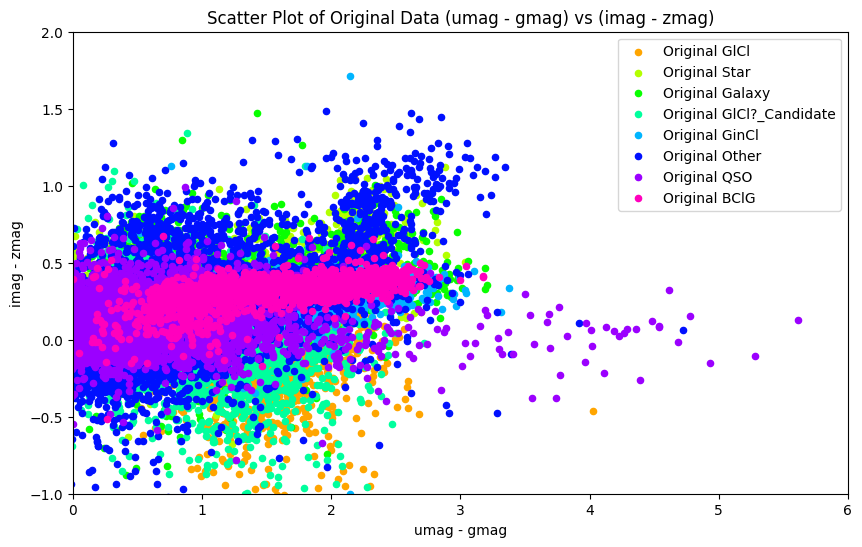

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'df' is your original dataframe and 'main_type_encoded' is the column with encoded labels
# Convert the original encoded labels back to their original class labels
df['main_type_original'] = label_encoder.inverse_transform(df['main_type_encoded'])

print("Original Data Labels:", df['main_type_original'].unique())



# Define your specific classes
classes = np.array(['GlCl', 'Star','Galaxy',  'GlCl?_Candidate', 'GinCl',  'Other' , 'QSO', 'BClG'])
colors = sns.color_palette('hsv', len(classes))

# Plot the results for the original dataframe with original labels
plt.figure(figsize=(10, 6))

# Highlight different original classes with different colors
for class_label, color in zip(classes, colors):
    class_indices = df['main_type_original'] == class_label
    plt.scatter(
        df['U_MAG_ISO_minus_G_MAG_ISO'][class_indices],  # x-axis values for the class
        df['I_MAG_ISO_minus_Z_MAG_ISO'][class_indices],  # y-axis values for the class
        c=[color],  # Color for these points
        s=20,
        label=f'Original {class_label}'  # Label for legend
    )

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
plt.xlim(0, 6)  # Limit the range for x-axis
plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of Original Data (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()

df = df.drop(columns='main_type_original')

########### Training on XGBoost
############
############
###########
###########

In [29]:
# X_train.shape

In [30]:
# y_test.hist()

In [31]:
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib
# import xgboost as xgb


# # Initialize the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# # Set up the parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# # Use GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Get the best model from grid search
# best_xgb_classifier = grid_search.best_estimator_

# # Predict the test set results
# y_pred = best_xgb_classifier.predict(X_test)

# # Evaluate the classifier
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}')
# print(report)

# # Decode the labels
# # Assuming you have label encoder and decoded labels from your previous steps
# decoded_labels = label_encoder.inverse_transform(np.unique(y_test))

# # Plot the confusion matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix with Decoded Labels')
# plt.show()

# # Save the trained model to a file
# model_filename = 'best_xgboost_model.pkl'
# joblib.dump(best_xgb_classifier, model_filename)
# print(f'Model saved to {model_filename}')

In [32]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib
# import xgboost as xgb
# import numpy as np
# from mapie.classification import MapieClassifier
# from mapie.metrics import classification_coverage_score



# y_train_encoded = y_train
# y_test_encoded = y_test


# # Initialize the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# # Train the XGBoost classifier
# xgb_classifier.fit(X_train, y_train_encoded)

# # Apply conformal prediction using the calibration set
# mapie_clf = MapieClassifier(estimator=xgb_classifier, method="score", cv="prefit")
# mapie_clf.fit(X_train, y_train_encoded)

# # Try different alpha levels to find the best coverage
# alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# best_alpha = 0
# best_coverage = 0

# for alpha in alphas:
#     y_pred, y_pis = mapie_clf.predict(X_test, alpha=alpha)
#     y_pis_transformed = np.array([set(np.where(y_pis[i])[0]) for i in range(len(y_pis))])
#     y_pis_boolean = np.zeros((len(y_test_encoded), len(np.unique(y_test_encoded))), dtype=bool)
#     for i in range(len(y_test_encoded)):
#         y_pis_boolean[i, list(y_pis_transformed[i])] = True
#     coverage = classification_coverage_score(y_test_encoded, y_pis_boolean)
#     print(f"Alpha: {alpha}, Coverage: {coverage:.2f}")
#     if coverage > best_coverage:
#         best_coverage = coverage
#         best_alpha = alpha

# print(f"Best Alpha: {best_alpha}, Best Coverage: {best_coverage:.2f}")

# # Final prediction with the best alpha
# y_pred, y_pis = mapie_clf.predict(X_test, alpha=best_alpha)

# # Evaluate the classifier
# accuracy = accuracy_score(y_test_encoded, y_pred)
# report = classification_report(y_test_encoded, y_pred)
# conf_matrix = confusion_matrix(y_test_encoded, y_pred)
# print(f'Accuracy: {accuracy:.2f}')
# print(report)

# # Decode the labels
# decoded_labels = label_encoder.inverse_transform(np.unique(y_test_encoded))

# # Plot the confusion matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix with Decoded Labels')
# plt.show()

# # Save the trained model to a file
# model_filename = 'xgboost_model_multi_classification.pkl'
# joblib.dump(xgb_classifier, model_filename)
# print(f'Model saved to {model_filename}')


In [33]:
# # Print the mapping between original labels and encoded values
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Label Mapping:", label_mapping)

# # Decode the labels using the dictionary
# decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
# print(decoded_labels)





In [34]:
# # Assuming label_encoder is already fitted
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# # Print the key-value pairs
# for original_label, encoded_value in label_mapping.items():
#     print(f"{original_label}: {encoded_value}")

In [35]:
# y_train.hist()

In [36]:
# y_test.hist()

In [37]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Make predictions on the test set
# test_data_pred = best_xgb_classifier.predict(X_test)
# final_pred_labels_test = label_encoder.inverse_transform(test_data_pred)


# # Define your specific classes
# classes = np.array(['GlCl', 'Star','Galaxy',  'GlCl?_Candidate', 'GinCl',  'Other' , 'QSO', 'BClG'])
# colors = sns.color_palette('hsv', len(classes))

# # Plot the results for the test set
# plt.figure(figsize=(10, 6))

# # Highlight different original classes with different colors
# for class_label, color in zip(classes, colors):
#     class_indices = final_pred_labels_test == class_label
#     plt.scatter(
#         X_test['U_MAG_ISO_minus_G_MAG_ISO'][class_indices],  # x-axis values for the class
#         X_test['I_MAG_ISO_minus_Z_MAG_ISO'][class_indices],  # y-axis values for the class
#         c=[color],  # Color for these points
#         s=20,
#         label=f'predicted {class_label}'  # Label for legend
#     )

# # Add labels and title
# plt.xlabel('umag - gmag')  # Label for x-axis
# plt.ylabel('imag - zmag')  # Label for y-axis
# plt.xlim(0, 6)  # Limit the range for x-axis
# plt.ylim(-1, 2)  # Limit the range for y-axis
# plt.legend()  # Add legend to the plot
# plt.title('Scatter Plot of Test Data (umag - gmag) vs (imag - zmag)')  # Title of the plot

# # Display the plot
# plt.show()


In [38]:
# unlabeled_data_proba = best_xgb_classifier.predict_proba(unlabeled_data)

# # Initialize an array to store the final predictions
# unlabeled_data_pred = np.argmax(unlabeled_data_proba, axis=1)

# # Convert final predictions to original class labels
# final_pred_labels = label_encoder.inverse_transform(unlabeled_data_pred)

# print(final_pred_labels)
# np.unique(final_pred_labels)



# # Define your specific classes
# classes = np.array(['GlCl', 'Star','Galaxy',  'GlCl?_Candidate', 'GinCl',  'Other' , 'QSO', 'BClG'])
# colors = sns.color_palette('hsv', len(classes))

# # Plot the results
# plt.figure(figsize=(10, 6))




# # Perform stratified sampling to keep the distribution
# sampled_indices, _ = train_test_split(
#     np.arange(len(final_pred_labels)),
#     test_size=0.9,
#     stratify=final_pred_labels,
#     random_state=42
# )

# # Create the sampled data
# sampled_unlabeled_data = unlabeled_data.iloc[sampled_indices]
# sampled_final_pred_labels = final_pred_labels[sampled_indices]






# # Highlight different predicted classes with different colors
# for class_label, color in zip(classes, colors):
#     class_indices = sampled_final_pred_labels == class_label
#     plt.scatter(
#         sampled_unlabeled_data['U_MAG_ISO_minus_G_MAG_ISO'][class_indices],  # x-axis values for the class
#         sampled_unlabeled_data['I_MAG_ISO_minus_Z_MAG_ISO'][class_indices],  # y-axis values for the class
#         c=[color],  # Color for these points
#         s=20,
#         alpha=0.6,

#         label=f'Predicted {class_label}'  # Label for legend
#     )

# # Add labels and title
# plt.xlabel('umag - gmag')  # Label for x-axis
# plt.ylabel('imag - zmag')  # Label for y-axis
# plt.xlim(0, 6)  # Limit the range for x-axis
# plt.ylim(-1, 2)  # Limit the range for y-axis
# plt.legend()  # Add legend to the plot
# plt.title('Scatter Plot of Unlabeled Data (umag - gmag) vs (imag - zmag)')  # Title of the plot

# # Display the plot
# plt.show()

In [39]:

# plt.hist(unlabeled_data_pred, bins=30, alpha=0.75)
# plt.title('Histogram')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.show()

In [40]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib
# import xgboost as xgb
# import xgboost as xgb
# from mapie.classification import MapieClassifier
# from mapie.metrics import classification_coverage_score


# # Initialize the XGBoost classifier
# xgb_classifier = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False)

# # Train the classifier
# xgb_classifier.fit(X_train, y_train)


# # Apply conformal prediction using the calibration set
# mapie_clf = MapieClassifier(xgb_classifier, method="score", cv="prefit")
# mapie_clf.fit(X_train, y_train)


# # Predict with confidence intervals
# y_pred, y_pis = mapie_clf.predict(X_test, alpha=0.99)  # 90% prediction intervals



# # Predict with prediction sets
# y_pred, y_pis = mapie_clf.predict(X_test, alpha=0.5)  # 50% prediction sets to significantly broaden intervals

# # Check the structure of y_pis and ensure it contains prediction sets
# print(f"Structure of y_pis: {y_pis.shape}")

# # Diagnose the number of classes included in the prediction sets
# num_classes_in_pis = np.sum(y_pis, axis=1)
# print(f"Number of classes in prediction sets: {np.unique(num_classes_in_pis, return_counts=True)}")

# # Check for samples where y_pis has more than one True
# samples_with_multiple_classes = [(i, np.where(y_pis[i])[0]) for i in range(len(y_pis)) if np.sum(y_pis[i]) > 1]

# # Print the indices and prediction sets of such samples
# print("Samples with multiple classes in prediction sets:")
# for sample in samples_with_multiple_classes:
#     print(f"Sample index: {sample[0]}, Prediction set: {sample[1]}")

# # Ensure y_pis is transformed correctly for coverage calculation
# y_pis_transformed = np.array([set(np.where(y_pis[i])[0]) for i in range(len(y_pis))])

# # Create a boolean array for coverage calculation
# y_pis_boolean = np.zeros((len(y_test), len(np.unique(y_test))), dtype=bool)
# for i in range(len(y_test)):
#     y_pis_boolean[i, list(y_pis_transformed[i])] = True

# # Calculate coverage
# coverage = classification_coverage_score(y_test, y_pis_boolean)
# print(f"Coverage: {coverage:.2f}")


In [41]:


# # Evaluate the classifier
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)

# print(f'Accuracy: {accuracy:.2f}')
# print('Classification Report:')
# print(report)

# # Print the mapping between original labels and encoded values
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Label Mapping:", label_mapping)

# # Decode the labels using the dictionary
# decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
# print(decoded_labels)

# # Plot the confusion matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix with Decoded Labels')
# plt.show()

# # Save the trained model to a file
# model_filename = 'xgboost_model.pkl'
# joblib.dump(xgb_classifier, model_filename)
# print(f'Model saved to {model_filename}')


In [42]:
# # Get the index of the label 'GLCL'
# glcl_index = label_mapping["GLCL"]

# # Extract the row and column corresponding to 'GLCL' in the confusion matrix
# glcl_conf_matrix_row = conf_matrix[glcl_index, :]
# glcl_conf_matrix_col = conf_matrix[:, glcl_index]

# # Calculate the number of true positives, false positives, false negatives, and true negatives for 'GLCL'
# true_positives_glcl = glcl_conf_matrix_row[glcl_index]
# false_positives_glcl = sum(glcl_conf_matrix_col) - true_positives_glcl
# false_negatives_glcl = sum(glcl_conf_matrix_row) - true_positives_glcl
# true_negatives_glcl = np.sum(conf_matrix) - (true_positives_glcl + false_positives_glcl + false_negatives_glcl)

# # Calculate the accuracy for 'GLCL'
# accuracy_glcl = (true_positives_glcl + true_negatives_glcl) / np.sum(conf_matrix)

# print(f'Number of correct predictions for label GLCL: {true_positives_glcl}')
# print(f'Number of false predictions for label GLCL: {false_negatives_glcl + false_positives_glcl}')
# print(f'Accuracy for label GLCL: {accuracy_glcl:.2f}')



In [43]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Number of classes
# num_classes = conf_matrix.shape[0]

# # Initialize lists to store precision, recall, and f1 score for each label
# precisions = []
# recalls = []
# f1_scores = []



# # Calculate precision, recall, and f1 score for each class
# for i in range(num_classes):
#     tp = conf_matrix[i, i]
#     fp = np.sum(conf_matrix[:, i]) - tp
#     fn = np.sum(conf_matrix[i, :]) - tp

#     precision = tp / (tp + fp) if (tp + fp) != 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) != 0 else 0
#     f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

#     precisions.append(precision)
#     recalls.append(recall)
#     f1_scores.append(f1_score)

# # Plot Precision, Recall, and F1 Score for each class
# labels = list(label_mapping.keys())
# x = np.arange(len(labels))
# bar_width = 0.3

# plt.figure(figsize=(16, 6))

# # Plot Precision
# plt.subplot(1, 3, 1)
# plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('Precision')
# plt.title('Precision for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(precisions):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# # Plot Recall
# plt.subplot(1, 3, 2)
# plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('Recall')
# plt.title('Recall for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(recalls):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# # Plot F1 Score
# plt.subplot(1, 3, 3)
# plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('F1 Score')
# plt.title('F1 Score for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(f1_scores):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# plt.tight_layout()
# plt.show()


############## Binary Classification with catboost

In [44]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib
# import catboost as cb
# import numpy as np
# from mapie.classification import MapieClassifier
# from mapie.metrics import classification_coverage_score
# from sklearn.model_selection import GridSearchCV
# from catboost import CatBoostClassifier



# # Decode the encoded labels back to the original labels
# y_train_decoded = label_encoder.inverse_transform(y_train)
# y_test_decoded = label_encoder.inverse_transform(y_test)
# y_calib_decoded = label_encoder.inverse_transform(y_calib)



# # Important class
# important_class = "GLCL"

# # Converting to binary labels
# y_train_binary = pd.Series([1 if label == important_class else 0 for label in y_train_decoded])
# y_test_binary = pd.Series([1 if label == important_class else 0 for label in y_test_decoded])
# y_calib_binary = pd.Series([1 if label == important_class else 0 for label in y_calib_decoded])

# # Create a mapping for visualization
# binary_to_original_mapping = {
#     1: important_class,
#     0: 'Other'
# }
# # Define the hyperparameter grid for CatBoost
# param_grid = {
#     'iterations': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'depth': [3, 5, 7],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bylevel': [0.6, 0.8, 1.0]
# }

# # Initialize the CatBoost classifier
# catboost_classifier = CatBoostClassifier(random_seed=42, verbose=0)  # Ensure verbose is set to 0 for GridSearchCV

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=catboost_classifier, param_grid=param_grid, 
#                            scoring='f1', cv=5, verbose=1, n_jobs=-1)

# # Fit the GridSearchCV model
# grid_search.fit(X_train, y_train_binary)

# # Best parameters and best score
# print("Best parameters found: ", grid_search.best_params_)
# print("Best accuracy Score: ", grid_search.best_score_)

# # Get the best estimator
# best_catg = grid_search.best_estimator_

# # Train the XGBoost classifier with the best estimator
# best_catg.fit(X_train, y_train_binary)

# # Get predicted probabilities
# y_pred_proba = best_catg.predict_proba(X_test)[:, 1]

# # Function to evaluate different thresholds
# def evaluate_thresholds_for_accuracy(y_test, y_pred_proba, thresholds):
#     best_threshold = 0.5
#     best_accuracy = 0.0
#     for threshold in thresholds:
#         y_pred = (y_pred_proba >= threshold).astype(int)
#         accuracy = accuracy_score(y_test, y_pred)
#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             best_threshold = threshold
#     return best_threshold, best_accuracy

# # Define the range of thresholds to evaluate
# thresholds = [i * 0.01 for i in range(100)]

# # Find the best threshold for accuracy
# best_threshold, best_accuracy = evaluate_thresholds_for_accuracy(y_test_binary, y_pred_proba, thresholds)


# # Predict using the best threshold
# y_pred = (y_pred_proba >= best_threshold).astype(int)

# # Evaluate the model with the best threshold
# print("Best Threshold:", best_threshold)
# print("Best accuracy Score:", best_accuracy)

# # Evaluate the classifier
# accuracy = accuracy_score(y_test_binary, y_pred)
# report = classification_report(y_test_binary, y_pred)
# conf_matrix = confusion_matrix(y_test_binary, y_pred)
# print(f'Accuracy: {accuracy:.2f}')

# # Decode the labels using the dictionary
# decoded_labels = [binary_to_original_mapping[key] for key in sorted(binary_to_original_mapping)]

# # Plot the confusion matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix with Decoded Labels')
# plt.show()

# # Save the trained model to a file
# model_filename = 'catboost_model_Binary_Classification.pkl'
# joblib.dump(catboost_classifier, model_filename)
# print(f'Model saved to {model_filename}')


In [45]:
# # Initialize Mapie for conformal prediction
# mapie = MapieClassifier(estimator=best_catg, method="score", cv="prefit")

# # Fit the conformal predictor on training and calibration data combined
# mapie.fit(X_calib, y_calib_binary)

# # Get prediction intervals for probabilities
# prediction, prediction_intervals = mapie.predict(X_test, alpha=0.05)

# # Inspect the shape of prediction_intervals
# print("Prediction Intervals Shape:", prediction_intervals.shape)

# # Extract lower and upper bounds for probabilities
# lower_bounds = prediction_intervals[:, 0, 0]
# upper_bounds = prediction_intervals[:, 1, 0]

# # Calculate the error bars
# yerr_lower = y_pred_proba - lower_bounds
# yerr_upper = upper_bounds - y_pred_proba

# # Ensure yerr contains no negative values
# yerr_lower = np.maximum(0, yerr_lower)
# yerr_upper = np.maximum(0, yerr_upper)

# # Combine probabilities and intervals into a DataFrame
# results_df = pd.DataFrame({
#     'Predicted Probability': y_pred_proba,
#     'Predicted Label': y_pred,
#     'Lower Bound': lower_bounds,
#     'Upper Bound': upper_bounds,
#     'True Label': y_test_binary
# })

# # Calculate coverage
# coverage = classification_coverage_score(y_test_binary, prediction_intervals[:, :, 0])
# print("Coverage:", coverage)

# # Print and visualize the results
# print(results_df.head())

# # Sample a subset of the data
# sample_size = 50  # Adjust this to a suitable number for your data
# sampled_df = results_df.sample(n=sample_size, random_state=42)

# # Extract the sampled data
# sampled_indices = sampled_df.index
# sampled_predicted_probabilities = sampled_df['Predicted Probability'].values
# sampled_lower_bounds = sampled_df['Lower Bound'].values
# sampled_upper_bounds = sampled_df['Upper Bound'].values

# # Calculate the error bars
# sampled_yerr_lower = sampled_predicted_probabilities - sampled_lower_bounds
# sampled_yerr_upper = sampled_upper_bounds - sampled_predicted_probabilities

# # Ensure yerr contains no negative values
# sampled_yerr_lower = np.maximum(0, sampled_yerr_lower)
# sampled_yerr_upper = np.maximum(0, sampled_yerr_upper)

# # Plot the sampled data
# plt.figure(figsize=(10, 5))
# plt.errorbar(range(len(sampled_predicted_probabilities)), sampled_predicted_probabilities, yerr=[sampled_yerr_lower, sampled_yerr_upper], fmt='o')
# plt.xlabel('Sample Index')
# plt.ylabel('Predicted Probability with Intervals')
# plt.title('Sampled Predicted Probabilities with Conformal Prediction Intervals')
# plt.show()

In [46]:
# Decode the encoded labels back to the original labels
y_train_decoded = label_encoder.inverse_transform(y_train)
y_test_decoded = label_encoder.inverse_transform(y_test)
y_calib_decoded = label_encoder.inverse_transform(y_calib)

###########Training on xgboost with binary classification#########

In [47]:
# Use np.unique to count unique values
unique_values, counts = np.unique(y_test_decoded, return_counts=True)

# Display the counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

BClG: 423
Galaxy: 2908
GinCl: 1269
GlCl: 1005
GlCl?_Candidate: 832
Other: 1316
QSO: 807
Star: 890


In [48]:


# Important class
important_class = "GlCl"

# Converting to binary labels
y_train_binary = pd.Series([1 if label == important_class else 0 for label in y_train_decoded])
y_test_binary = pd.Series([1 if label == important_class else 0 for label in y_test_decoded])
y_calib_binary = pd.Series([1 if label == important_class else 0 for label in y_calib_decoded])

In [49]:
# Use np.unique to count unique values
unique_values, counts = np.unique(y_test_binary, return_counts=True)

# Display the counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 8445
1: 1005


<Axes: >

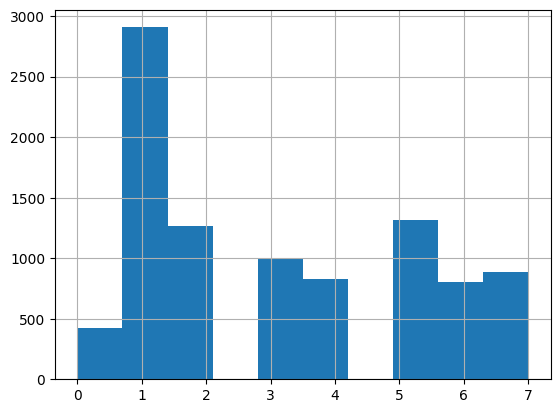

In [50]:
y_test.hist()

In [51]:
# Check class distribution in the training set
print("Class distribution in y_train_binary:")
print(np.bincount(y_train_binary))

Class distribution in y_train_binary:
[27021  3216]


Class distribution in y_train_binary:
[27021  3216]


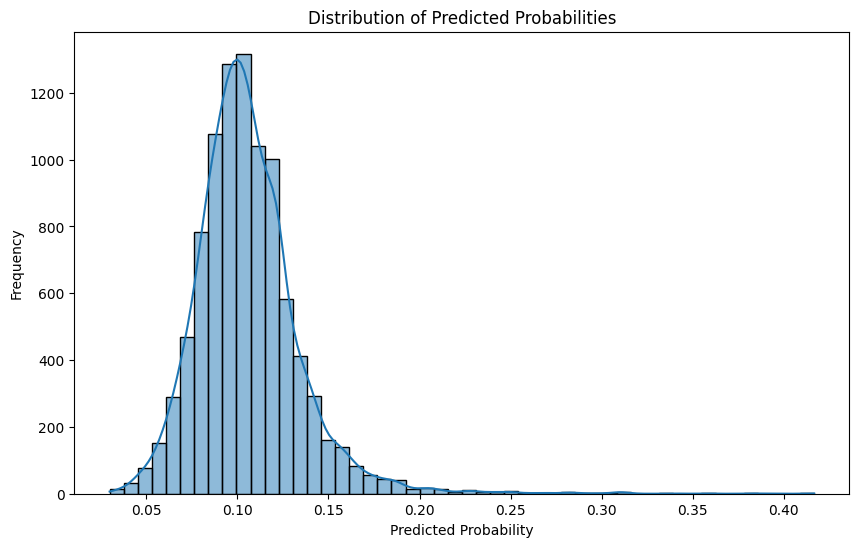

Threshold: 0.1 - F1 Score: 0.18
Threshold: 0.2 - F1 Score: 0.02
Threshold: 0.3 - F1 Score: 0.00
Threshold: 0.4 - F1 Score: 0.00
Threshold: 0.5 - F1 Score: 0.00
Threshold: 0.6 - F1 Score: 0.00
Threshold: 0.7 - F1 Score: 0.00
Threshold: 0.8 - F1 Score: 0.00
Best Threshold: 0.1 - Best F1 Score: 0.18


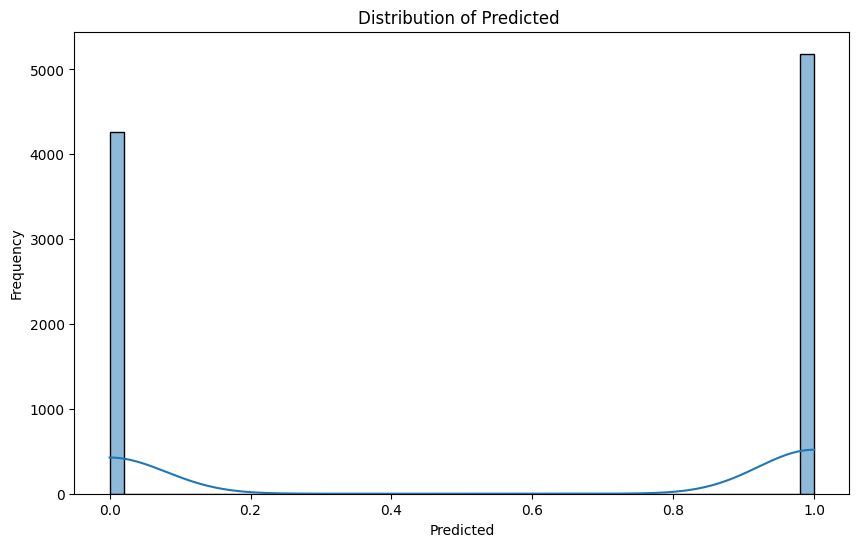

Accuracy: 0.46
              precision    recall  f1-score   support

           0       0.89      0.45      0.60      8445
           1       0.11      0.55      0.18      1005

    accuracy                           0.46      9450
   macro avg       0.50      0.50      0.39      9450
weighted avg       0.81      0.46      0.55      9450



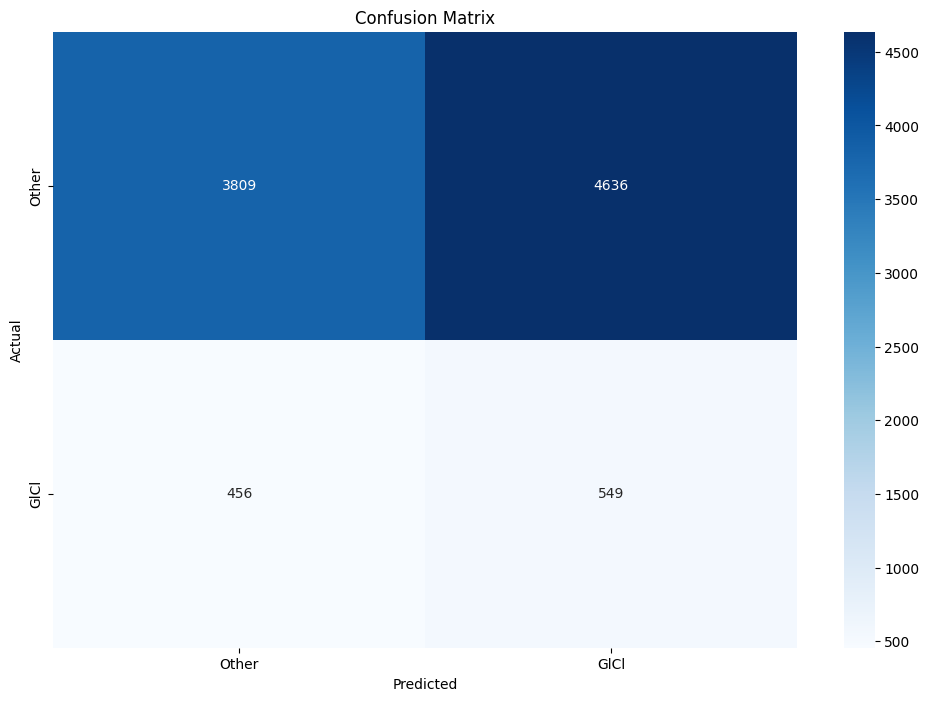

Model saved to xgboost_model_Binary_Classification.pkl


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import numpy as np

# Initialize the XGBoost classifier with predefined hyperparameters
xgb_classifier = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8
)

# Train the XGBoost classifier
xgb_classifier.fit(X_train, y_train_binary)

# Predict probabilities
y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

# Check class distribution in the training set
print("Class distribution in y_train_binary:")
print(np.bincount(y_train_binary))

# Print the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()




# Initialize variables to find the best threshold
best_threshold = 0.5
best_f1_score = 0
best_conf_matrix = None

# Adjust the threshold and evaluate
thresholds = np.arange(0.1, 0.9, 0.1)
for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    current_f1_score = f1_score(y_test_binary, y_pred_adjusted)
    print(f'Threshold: {threshold:.1f} - F1 Score: {current_f1_score:.2f}')
    
    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_threshold = threshold
        best_conf_matrix = confusion_matrix(y_test_binary, y_pred_adjusted)

print(f'Best Threshold: {best_threshold:.1f} - Best F1 Score: {best_f1_score:.2f}')

# Use the best threshold for classification
y_pred = (y_pred_proba >= best_threshold).astype(int)


# Print the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=50, kde=True)
plt.title('Distribution of Predicted ')
plt.xlabel('Predicted')
plt.ylabel('Frequency')
plt.show()

# Evaluate the classifier with the best threshold
accuracy = accuracy_score(y_test_binary, y_pred)
report = classification_report(y_test_binary, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(report)

# Decode the labels using the dictionary
binary_to_original_mapping = {
    1: 'GlCl',
    0: 'Other'
}
decoded_labels = [binary_to_original_mapping[key] for key in sorted(binary_to_original_mapping)]

# Plot the confusion matrix for the best threshold
plt.figure(figsize=(12, 8))
sns.heatmap(best_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.title(f'Confusion Matrix with Best Threshold {best_threshold:.1f}')
plt.title(f'Confusion Matrix')

plt.show()

# Save the trained model to a file
model_filename = 'xgboost_model_Binary_Classification.pkl'
joblib.dump(xgb_classifier, model_filename)
print(f'Model saved to {model_filename}')


In [53]:
# Use np.unique to count unique values
unique_values, counts = np.unique(y_pred, return_counts=True)

# Display the counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 4265
1: 5185


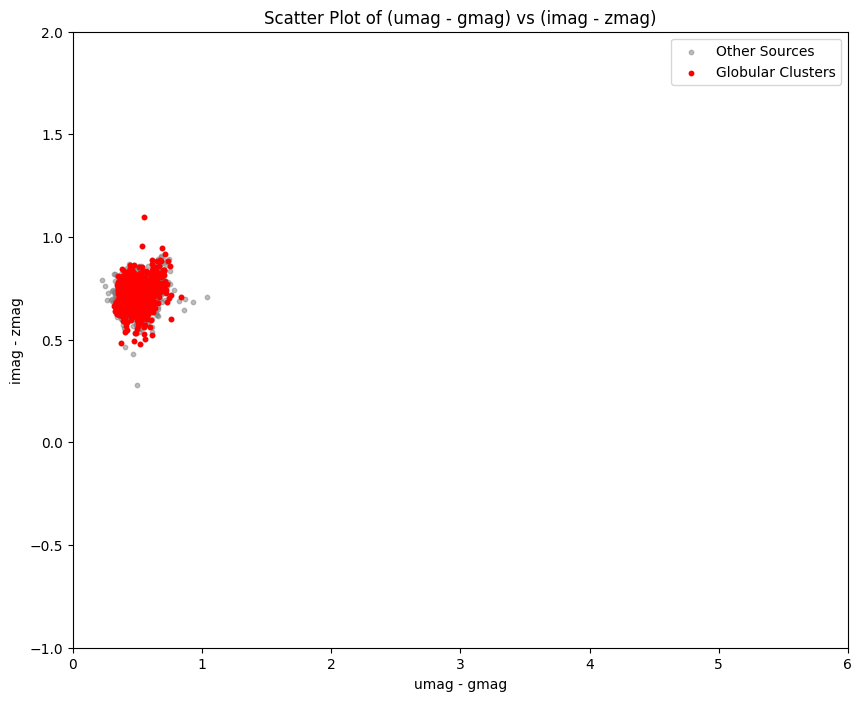

In [54]:
#  Scatter plot of (umag - gmag) vs (imag - zmag) with globular clusters highlighted
plt.figure(figsize=(10, 8))  # Create a figure with specified size

# Plot other sources
plt.scatter(
    X_test['U_MAG_ISO_minus_G_MAG_ISO'],  # Difference between umag and gmag for x-axis
    X_test['I_MAG_ISO_minus_Z_MAG_ISO'],  # Difference between imag and zmag for y-axis
    c='gray',  # Color for these points
    s=10,
    alpha=0.5,  # Transparency level
    label='Other Sources'  # Label for legend
)

# Highlight globular clusters
plt.scatter(
    X_test['U_MAG_ISO_minus_G_MAG_ISO'][y_pred == 1],  # x-axis values for predicted globular clusters
    X_test['I_MAG_ISO_minus_Z_MAG_ISO'][y_pred == 1],  # y-axis values for predicted globular clusters
    c='red',  # Color for these points
    s=10,
    label='Globular Clusters'  # Label for legend
)

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
plt.xlim(0, 6)  # Limit the range for x-axis
plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()



Unlabeled Data Analysis

In [55]:
galaxies_df.columns

Index(['# NGVS_name', 'Nickname', 'RA_in', 'DEC_in', 'g_mag_total'], dtype='object')

In [56]:
df_BD.columns

Index(['RA_in', 'DEC_in', 'A_WORLD', 'B_WORLD', 'THETA_WORLD', 'ERRA_WORLD',
       'ERRB_WORLD', 'ERRTHETA_WORLD', 'EBV', 'G_MAG_ISO', 'U_MAG_APER1',
       'G_MAG_APER1', 'R_MAG_APER1', 'I_MAG_APER1', 'Z_MAG_APER1',
       'U_MAG_APER3', 'G_MAG_APER3', 'R_MAG_APER3', 'I_MAG_APER3',
       'Z_MAG_APER3', 'U_MAG_APER5', 'G_MAG_APER5', 'R_MAG_APER5',
       'I_MAG_APER5', 'Z_MAG_APER5', 'U_MAGERR_APER1', 'G_MAGERR_APER1',
       'R_MAGERR_APER1', 'I_MAGERR_APER1', 'Z_MAGERR_APER1', 'U_MAGERR_APER3',
       'G_MAGERR_APER3', 'R_MAGERR_APER3', 'I_MAGERR_APER3', 'Z_MAGERR_APER3',
       'U_MAGERR_APER5', 'G_MAGERR_APER5', 'R_MAGERR_APER5', 'I_MAGERR_APER5',
       'Z_MAGERR_APER5', 'U_MU_MAX', 'G_MU_MAX', 'R_MU_MAX', 'I_MU_MAX',
       'Z_MU_MAX', 'U_BACKGROUND', 'G_BACKGROUND', 'R_BACKGROUND',
       'I_BACKGROUND', 'Z_BACKGROUND', 'U_ISOAREA_IMAGE', 'G_ISOAREA_IMAGE',
       'R_ISOAREA_IMAGE', 'I_ISOAREA_IMAGE', 'Z_ISOAREA_IMAGE', 'U_FWHM_IMAGE',
       'G_FWHM_IMAGE', 'R_FWHM_IMAGE', 'I

CSV files created successfully.


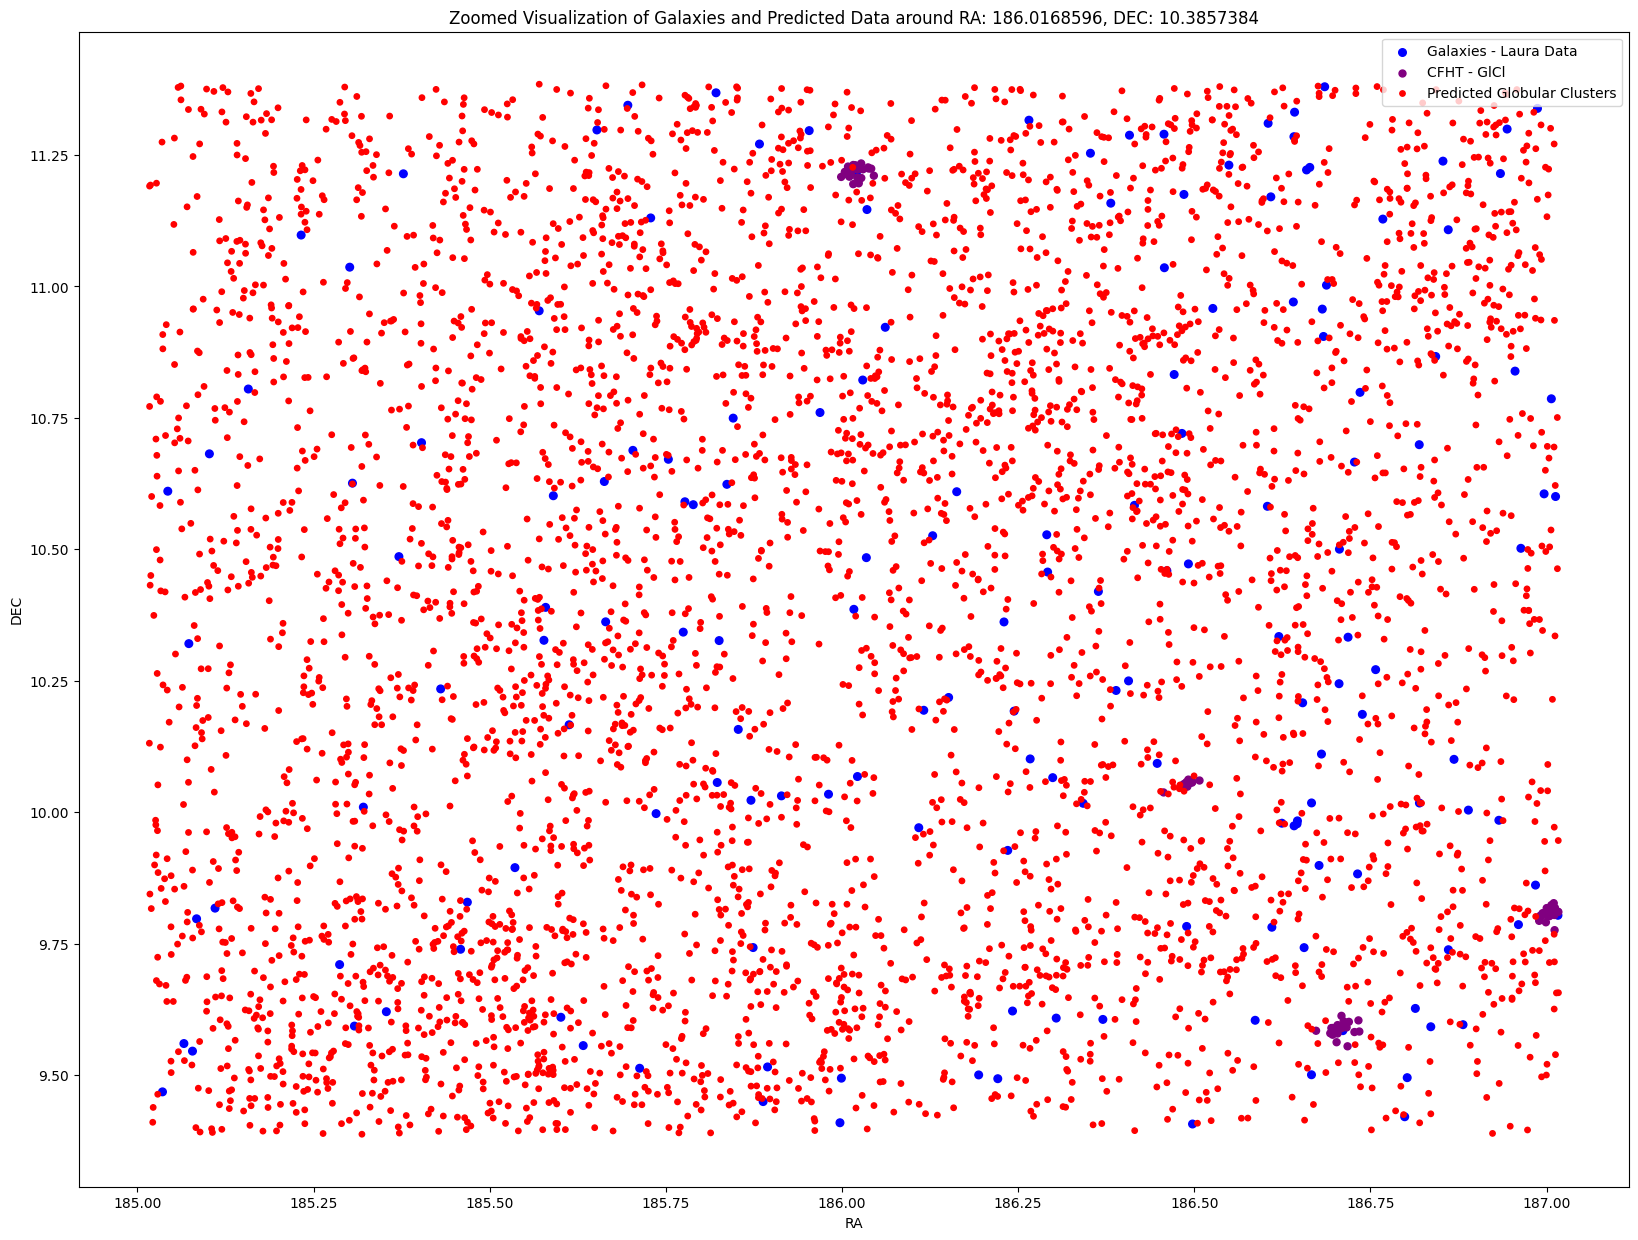

In [57]:
# Select a galaxy within the RA_in range 186-190
selected_galaxy = galaxies_df[(galaxies_df['RA_in'] >= 186) & (galaxies_df['RA_in'] <= 190)].iloc[10]
center_ra = selected_galaxy['RA_in']
center_dec = selected_galaxy['DEC_in']
# Creating a DataFrame for the selected galaxy
selected_galaxy_df = pd.DataFrame([selected_galaxy])
# Filter data within +/- 1 degree of the selected galaxy's coordinates
galaxies_zoom_df = galaxies_df[
    (galaxies_df['RA_in'] >= center_ra - 1) & (galaxies_df['RA_in'] <= center_ra + 1) &
    (galaxies_df['DEC_in'] >= center_dec - 1) & (galaxies_df['DEC_in'] <= center_dec + 1)
].copy()


df_zoom = df_BD[
    (df_BD['RA_in'] >= center_ra - 1) & (df_BD['RA_in'] <= center_ra + 1) &
    (df_BD['DEC_in'] >= center_dec - 1) & (df_BD['DEC_in'] <= center_dec + 1) &
    (df_BD['class'] == 'GlCl')
].copy()

# Rename columns to 'RA' and 'DEC' for consistency
selected_galaxy_df.rename(columns={'RA_in': 'RA', 'DEC_in': 'DEC'}, inplace=True)
galaxies_zoom_df.rename(columns={'RA_in': 'RA', 'DEC_in': 'DEC'}, inplace=True)
df_zoom.rename(columns={'RA_in': 'RA', 'DEC_in': 'DEC'}, inplace=True)



# Adding additional columns
selected_galaxy_df.loc[:, 'name'] = 'Selected Galaxy'
selected_galaxy_df.loc[:, 'color'] = 'red'
selected_galaxy_df.loc[:, 'radius'] = 10

galaxies_zoom_df.loc[:, 'name'] = 'Laura Galaxy'
galaxies_zoom_df.loc[:, 'color'] = 'blue'
galaxies_zoom_df.loc[:, 'radius'] = 10



# Define classes and corresponding colors
classes = ['GlCl']
colors = ['purple']
class_color_map = dict(zip(classes, colors))

# Adding color, radius, and name columns to df_zoom
df_zoom.loc[:, 'color'] = df_zoom['class'].map(class_color_map)
df_zoom.loc[:, 'radius'] = 5
df_zoom.loc[:, 'name'] = df_zoom['class']

# Unlabeled data predictions
unlabeled_data_proba = xgb_classifier.predict_proba(unlabeled_data)[:, 1]
unlabeled_data_pred = (unlabeled_data_proba >= 0.5).astype(int)
unlabeled_data_df = unlabeled_data_BD.copy()
unlabeled_data_df['RA'] = unlabeled_data_df['RA_in']
unlabeled_data_df['DEC'] = unlabeled_data_df['DEC_in']
unlabeled_data_df['name'] = unlabeled_data_proba
unlabeled_data_df['color'] = ['red' if pred == 1 else 'green' for pred in unlabeled_data_pred]
unlabeled_data_df['radius'] = 5



# Filter unlabeled data within the same zoomed area
unlabeled_data_df = unlabeled_data_df[
    (unlabeled_data_df['RA'] >= center_ra - 1) & (unlabeled_data_df['RA'] <= center_ra + 1) &
    (unlabeled_data_df['DEC'] >= center_dec - 1) & (unlabeled_data_df['DEC'] <= center_dec + 1) &
    (unlabeled_data_pred == 1)
]



# Format the scores to a readable percentage
unlabeled_data_df['name'] = unlabeled_data_df['name'].apply(lambda x: f'{x:.2%}')

# Save the DataFrames to CSV files
selected_galaxy_df.to_csv('selected_galaxy.csv', index=False)
galaxies_zoom_df.to_csv('galaxies_zoom.csv', index=False)
df_zoom.to_csv('df_zoom.csv', index=False)
unlabeled_data_df.to_csv('unlabeled_data_pred.csv', index=False)

# Combine the data into a single DataFrame for visualization with class information
combined_df = pd.concat([
    galaxies_zoom_df[['RA', 'DEC', 'name', 'color', 'radius']],
    df_zoom[['RA', 'DEC', 'name', 'color', 'radius']],
    unlabeled_data_df[['RA', 'DEC', 'name', 'color', 'radius']]
])



# Save the combined DataFrame to a CSV file
combined_df.to_csv('combined.csv', index=False)

print("CSV files created successfully.")

# Plotting
plt.figure(figsize=(20, 15))

# Plot filtered galaxies in blue with bigger markers and label 'Galaxies - Laura Data'
plt.scatter(galaxies_zoom_df['RA'], galaxies_zoom_df['DEC'], color='blue', s=galaxies_zoom_df['radius']*3, label='Galaxies - Laura Data')

# Plot filtered CFHT modified data with different colors for different classes and smaller markers
plt.scatter(df_zoom['RA'], df_zoom['DEC'], color='purple', s=df_zoom['radius']*5, label='CFHT - GlCl')

# Plot unlabeled data predictions
plt.scatter(unlabeled_data_df['RA'], unlabeled_data_df['DEC'], color='red', s=unlabeled_data_df['radius']*3, label='Predicted Globular Clusters')

plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend()
plt.title(f'Zoomed Visualization of Galaxies and Predicted Data around RA: {center_ra}, DEC: {center_dec}')
plt.show()


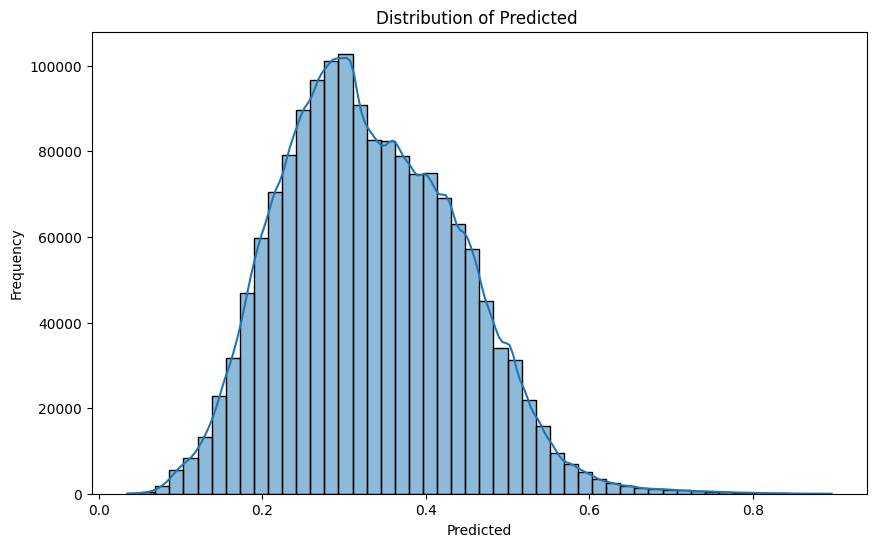

In [58]:
# Print the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(unlabeled_data_proba, bins=50, kde=True)
plt.title('Distribution of Predicted ')
plt.xlabel('Predicted')
plt.ylabel('Frequency')
plt.show()

In [59]:
# Make predictions on the unlabeled dataset
unlabeled_data_proba = xgb_classifier.predict_proba(unlabeled_data)[:, 1]
unlabeled_data_pred = (unlabeled_data_proba >= 0.35).astype(int)



In [60]:
# # Convert binary predictions to original labels using the mapping
# original_labels = np.array([binary_to_original_mapping[label] for label in unlabeled_data_pred])

# # Count occurrences of "GLCL" and "Other"
# glcl_count_un = np.sum(original_labels == "GLCL")
# other_count_un = np.sum(original_labels == "Other")
# total_count_un = len(original_labels)

# # Calculate percentage of "GLCL"
# glcl_percentage_un = (glcl_count_un / total_count_un) * 100

# print(f"Number of 'GLCL' labels in Unlabeled dataset: {glcl_count_un}")
# print(f"Number of 'Other' labels in Unlabeled dataset: {other_count_un}")
# print(f"Total number of labels in Unlabeled dataset: {total_count_un}")

# print(f"Percentage of 'GLCL' labels in Unlabeled dataset: {glcl_percentage_un:.2f}%")

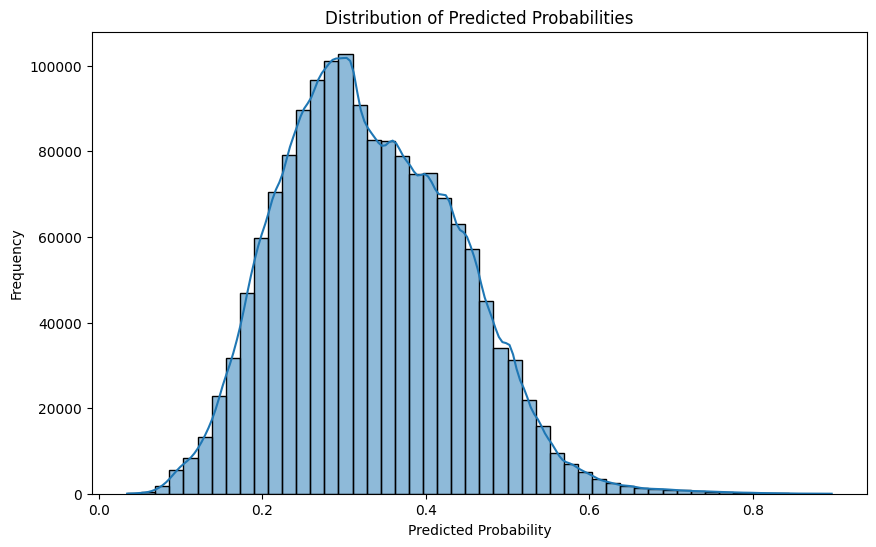

In [61]:
# Print the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(unlabeled_data_proba, bins=50, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

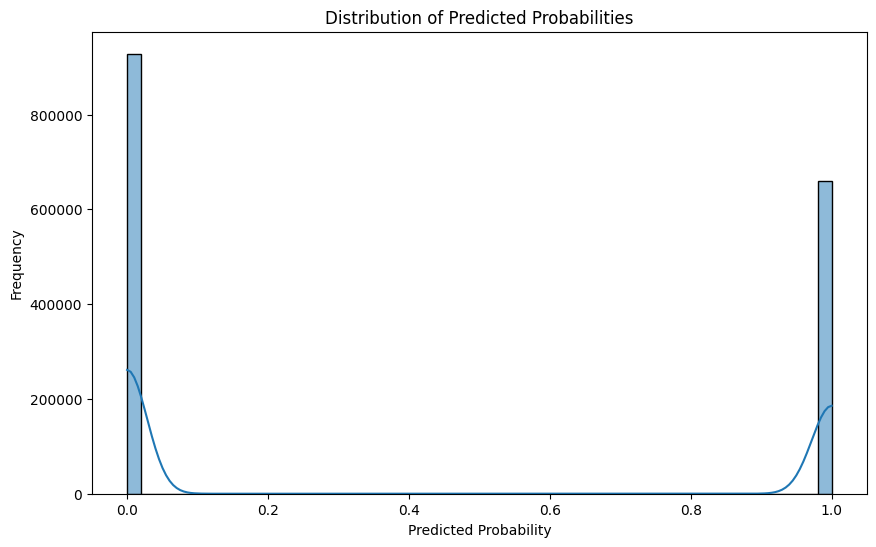

In [62]:
# Print the distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(unlabeled_data_pred, bins=50, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

/home/samanehjavadinia/.conda/envs/p120/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


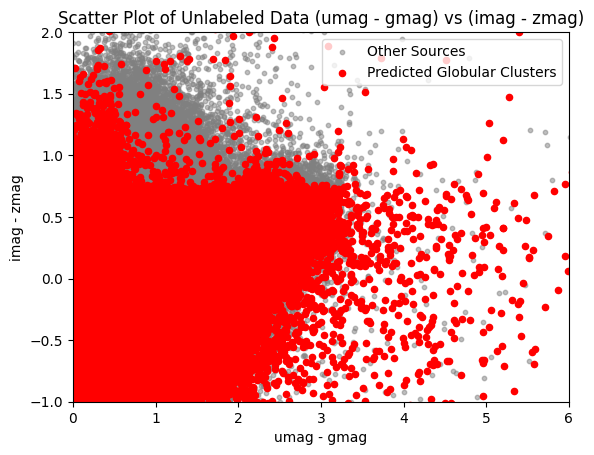

In [63]:
# Plot other sources
plt.scatter(
    unlabeled_data['U_MAG_ISO_minus_G_MAG_ISO'],  # Difference between umag and gmag for x-axis
    unlabeled_data['I_MAG_ISO_minus_Z_MAG_ISO'],  # Difference between imag and zmag for y-axis
    c='gray',  # Color for these points
    s=10,
    alpha=0.5,  # Transparency level
    label='Other Sources'  # Label for legend
)

# Highlight predicted globular clusters
plt.scatter(
    unlabeled_data['U_MAG_ISO_minus_G_MAG_ISO'][unlabeled_data_pred == 1],  # x-axis values for predicted globular clusters
    unlabeled_data['I_MAG_ISO_minus_Z_MAG_ISO'][unlabeled_data_pred == 1],  # y-axis values for predicted globular clusters
    c='red',  # Color for these points
    s=20,
    label='Predicted Globular Clusters'  # Label for legend
)

# Add labels and title
plt.xlabel('umag - gmag')  # Label for x-axis
plt.ylabel('imag - zmag')  # Label for y-axis
plt.xlim(0, 6)  # Limit the range for x-axis
plt.ylim(-1, 2)  # Limit the range for y-axis
plt.legend()  # Add legend to the plot
plt.title('Scatter Plot of Unlabeled Data (umag - gmag) vs (imag - zmag)')  # Title of the plot

# Display the plot
plt.show()

In [64]:
GLCL_Unlabeled = unlabeled_data[unlabeled_data_pred == 1]

In [71]:
GLCL_Unlabeled.shape

(659372, 93)

In [73]:
unlabeled_data.shape

(1587694, 93)

In [65]:
# import pandas as pd
# import numpy as np
# from sklearn.manifold import TSNE
# import umap.umap_ as umap
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler


# # Select the relevant columns for dimensionality reduction
# # features = ['umag', 'gmag', 'rmag', 'imag', 'zmag', ]
# features = ['umag_minus_gmag', 'umag_minus_rmag', 'umag_minus_imag',
#        'umag_minus_zmag', 'gmag_minus_rmag', 'gmag_minus_imag',
#        'gmag_minus_zmag', 'rmag_minus_imag', 'rmag_minus_zmag',
#        'imag_minus_zmag']

# unlabeled_data_features = unlabeled_data[features]

# # Standardize the data
# tsne_scaler = StandardScaler()
# unlabeled_data_scaled = tsne_scaler.fit_transform(unlabeled_data_features)

# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(unlabeled_data_scaled)

# # Create a DataFrame for the t-SNE results
# tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'],  index=unlabeled_data.index)

# # Apply UMAP
# umap_model = umap.UMAP(n_components=2, random_state=42)
# umap_results = umap_model.fit_transform(unlabeled_data_scaled)

# # Create a DataFrame for the UMAP results
# umap_df = pd.DataFrame(umap_results, columns=['UMAP1', 'UMAP2'],  index=unlabeled_data.index)


# # Visualize t-SNE results
# plt.figure(figsize=(10, 8))
# plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c='gray', s=10, alpha=0.5, label='Other Sources')
# plt.scatter(tsne_df['TSNE1'][unlabeled_data_pred == 1], tsne_df['TSNE2'][unlabeled_data_pred == 1], c='red', s=10, label='Predicted Globular Clusters')
# plt.xlabel('TSNE1')
# plt.ylabel('TSNE2')
# plt.legend()
# plt.title('t-SNE Scatter Plot of Unlabeled Data')
# plt.show()

# # Visualize UMAP results
# plt.figure(figsize=(10, 8))
# plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], c='gray', s=10, alpha=0.5, label='Other Sources')
# plt.scatter(umap_df['UMAP1'][unlabeled_data_pred == 1], umap_df['UMAP2'][unlabeled_data_pred == 1], c='red', s=10, label='Predicted Globular Clusters')
# plt.xlabel('UMAP1')
# plt.ylabel('UMAP2')
# plt.legend()
# plt.title('UMAP Scatter Plot of Unlabeled Data')
# plt.show()


Countdown the targets predicted on unlabeled data

In [66]:
# # Get unique values of the predicted labels
# unique_predictions = pd.Series(unlabeled_predictions_decoded).unique()
# print(f'Unique predicted labels: {unique_predictions}')

########### Training on Random Forest
############
############
###########
###########

In [67]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib
# # Initialize the Random Forest classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# # Train the classifier
# rf_classifier.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = rf_classifier.predict(X_test)

# # Evaluate the classifier
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)

# print(f'Accuracy: {accuracy:.2f}')
# print('Classification Report:')
# print(report)

# # Print the mapping between original labels and encoded values
# label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Label Mapping:", label_mapping)

# # Decode the labels using the dictionary
# decoded_labels = [key for key in sorted(label_mapping, key=label_mapping.get)]
# print(decoded_labels)

# # Plot the confusion matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix with Decoded Labels')
# plt.show()


# # Feature importance
# feature_importances = rf_classifier.feature_importances_
# features = X_train.columns

# # Plot feature importances
# plt.figure(figsize=(12, 8))
# sns.barplot(x=feature_importances, y=features)
# plt.xlabel('Feature Importance')
# plt.ylabel('Features')
# plt.title('Feature Importances in Random Forest Classifier')
# plt.show()

# # Save the trained model to a file
# model_filename = 'random_forest_model.pkl'
# joblib.dump(rf_classifier, model_filename)
# print(f'Model saved to {model_filename}')

In [68]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Number of classes
# num_classes = conf_matrix.shape[0]

# # Initialize lists to store precision, recall, and f1 score for each label
# precisions = []
# recalls = []
# f1_scores = []



# # Calculate precision, recall, and f1 score for each class
# for i in range(num_classes):
#     tp = conf_matrix[i, i]
#     fp = np.sum(conf_matrix[:, i]) - tp
#     fn = np.sum(conf_matrix[i, :]) - tp

#     precision = tp / (tp + fp) if (tp + fp) != 0 else 0
#     recall = tp / (tp + fn) if (tp + fn) != 0 else 0
#     f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

#     precisions.append(precision)
#     recalls.append(recall)
#     f1_scores.append(f1_score)

# # Plot Precision, Recall, and F1 Score for each class
# labels = list(label_mapping.keys())
# x = np.arange(len(labels))
# bar_width = 0.3

# plt.figure(figsize=(16, 6))

# # Plot Precision
# plt.subplot(1, 3, 1)
# plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('Precision')
# plt.title('Precision for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(precisions):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# # Plot Recall
# plt.subplot(1, 3, 2)
# plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('Recall')
# plt.title('Recall for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(recalls):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# # Plot F1 Score
# plt.subplot(1, 3, 3)
# plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('F1 Score')
# plt.title('F1 Score for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(f1_scores):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# plt.tight_layout()
# plt.show()

######## Training on random Forest by Binarization #######

In [69]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import joblib

# # Decode the encoded labels back to the original labels
# y_train_decoded = label_encoder.inverse_transform(y_train)
# y_test_decoded = label_encoder.inverse_transform(y_test)

# # Important class
# important_class = "GLCL"

# # Converting to binary labels
# y_train_binary = pd.Series([1 if label == important_class else 0 for label in y_train_decoded])
# y_test_binary = pd.Series([1 if label == important_class else 0 for label in y_test_decoded])

# # Create a mapping for visualization
# binary_to_original_mapping = {
#     1: important_class,
#     0: 'Other'
# }

# # Initialize the Random Forest classifier
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# # Train the classifier
# rf_classifier.fit(X_train, y_train_binary)

# # Make predictions on the test set
# y_pred = rf_classifier.predict(X_test)

# # Evaluate the classifier
# accuracy = accuracy_score(y_test_binary, y_pred)
# report = classification_report(y_test_binary, y_pred)
# conf_matrix = confusion_matrix(y_test_binary, y_pred)

# print(f'Accuracy: {accuracy:.2f}')
# print('Classification Report:')
# print(report)

# # Decode the labels using the dictionary
# decoded_labels = [binary_to_original_mapping[key] for key in sorted(binary_to_original_mapping)]

# # Plot the confusion matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=decoded_labels, yticklabels=decoded_labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix with Decoded Labels')
# plt.show()

# # Save the trained model to a file
# model_filename = 'RandomForest_model_Binary_Classification.pkl'
# joblib.dump(rf_classifier, model_filename)
# print(f'Model saved to {model_filename}')


In [70]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Initialize lists to store precision, recall, accuracy, and F1 score for each label
# precisions = []
# recalls = []
# f1_scores = []

# print(binary_to_original_mapping.items())

# # Calculate precision, recall, accuracy, and F1 score for each label
# for index, label in binary_to_original_mapping.items():  # Swap label and index
#     print(f"Processing index: {index}, label: {label}")
    
#     if index == 1:
#         print("Index is 1")
#         # True Positives (TP): Diagonal element for the current label
#         tp = conf_matrix[1, 1]

#         # False Positives (FP): Sum of the column for the current label excluding the diagonal element
#         fp = conf_matrix[0, 1]

#         # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
#         fn = conf_matrix[1, 0]

#         # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
#         tn = conf_matrix[0, 0]
#     elif index == 0:
#         print("Index is 0")
#         # True Positives (TP): Diagonal element for the current label
#         tp = conf_matrix[0, 0]

#         # False Positives (FP): Sum of the column for the current label excluding the diagonal element
#         fp = conf_matrix[1, 0]

#         # False Negatives (FN): Sum of the row for the current label excluding the diagonal element
#         fn = conf_matrix[0, 1]

#         # True Negatives (TN): Sum of all elements in the matrix excluding the current row and column
#         tn = conf_matrix[1, 1]
#     else:
#         assert False, f"Unexpected label value: {index}"  # Assert for unexpected values
#         print("Index is neither 0 nor 1, skipping this index")
#         continue  # Skip labels not covered in the binary mapping

#     # Calculate Precision
#     precision = tp / (tp + fp) if (tp + fp) != 0 else 0
#     precisions.append(precision)

#     # Calculate Recall
#     recall = tp / (tp + fn) if (tp + fn) != 0 else 0
#     recalls.append(recall)

#     # Calculate F1 Score
#     f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
#     f1_scores.append(f1_score)

# # Plot Precision, Recall, and F1 Score for each label
# labels = list(binary_to_original_mapping.values())
# x = np.arange(len(labels))

# bar_width = 0.3

# plt.figure(figsize=(16, 6))

# # Plot Precision
# plt.subplot(1, 3, 1)
# plt.bar(x, precisions, width=bar_width, color='b', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('Precision')
# plt.title('Precision for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(precisions):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# # Plot Recall
# plt.subplot(1, 3, 2)
# plt.bar(x, recalls, width=bar_width, color='g', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('Recall')
# plt.title('Recall for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(recalls):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# # Plot F1 Score
# plt.subplot(1, 3, 3)
# plt.bar(x, f1_scores, width=bar_width, color='m', alpha=0.7)
# plt.xticks(x, labels, rotation=90)
# plt.xlabel('Class')
# plt.ylabel('F1 Score')
# plt.title('F1 Score for each class')
# plt.ylim(0, 1.1)
# for i, v in enumerate(f1_scores):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', color='black')

# plt.tight_layout()
# plt.show()